In [10]:
!pip install aerosandbox

import os
import sys

import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, ReLU, Conv2DTranspose, Conv2D, Reshape, Dropout, Flatten
import random

# Set random seeds for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

from aerosandbox import Airfoil, KulfanAirfoil

import pandas as pd

import plotly.graph_objects as go

Coordinates shape:  (3, 79, 2)


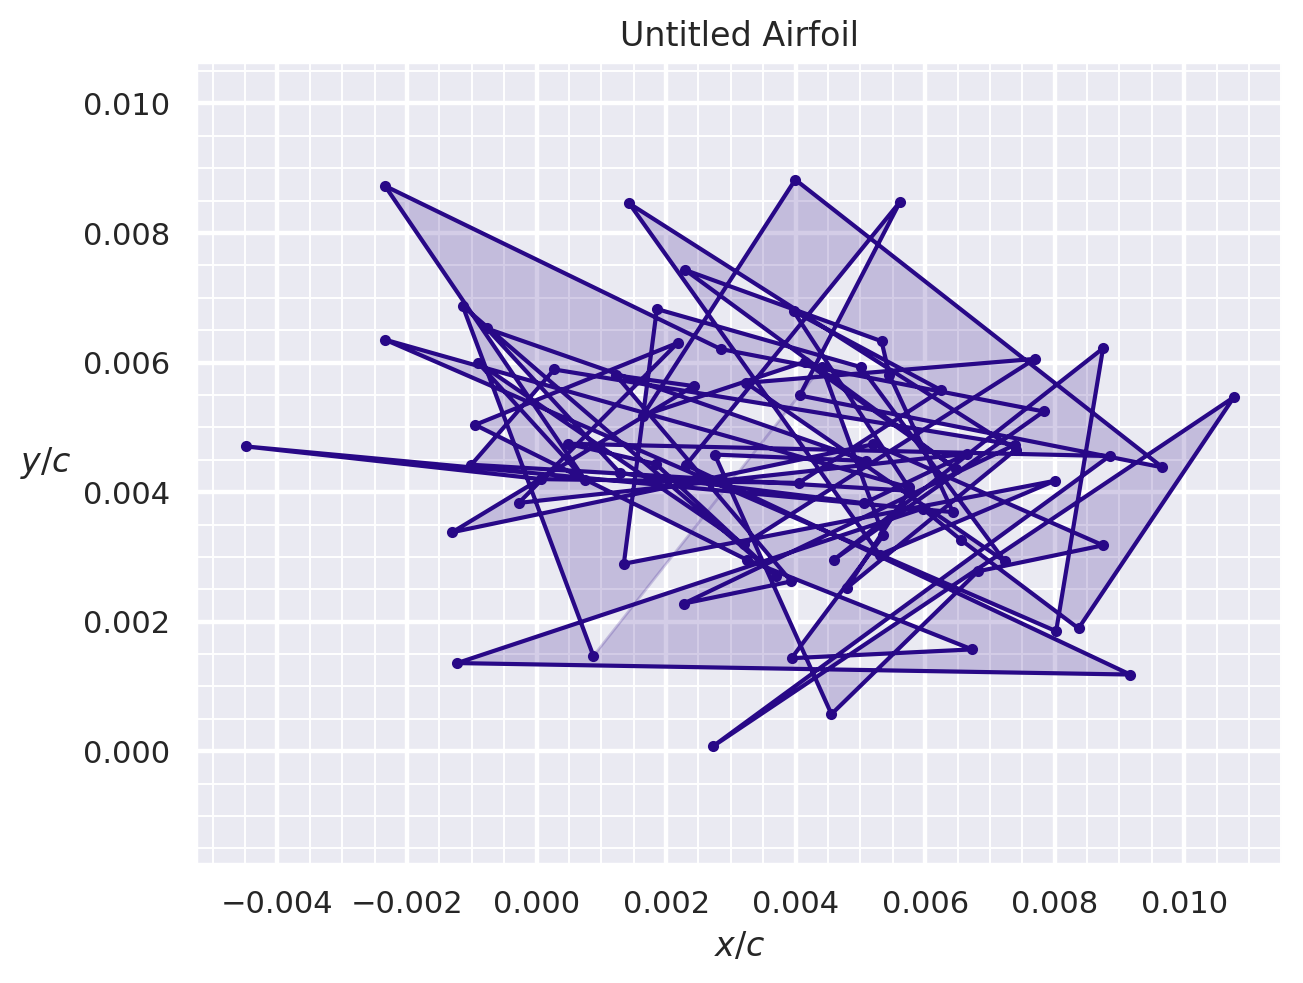

In [11]:
class Generator(tf.keras.Model):
    '''
    * Refs:
        - Lin, Jinxing & Zhang, Chenliang & Xie, Xiaoye & Shi, Xingyu & Xu, Xiaoyu & Duan, Yanhui. (2022). CST-GANs: A Generative Adversarial Network Based on CST Parameterization for the Generation of Smooth Airfoils. 600-605. 10.1109/ICUS55513.2022.9987080.
    '''
    def __init__(self, latent_dim: int = 128, kernel_size: tuple = (4,2), depth: int = 256, n_points: int = 149):
        super().__init__()

        # --- Parameters ---

        self.latent_dim = latent_dim
        self.kernel_size = kernel_size
        self.depth = depth
        self.n_points = n_points

        # --- Layers ---

        # Fully connected layers
        self.dense1 = Dense(self.depth * 2 * self.n_points)
        self.batch1 = BatchNormalization(momentum=0.9)
        self.leaky_relu1 = LeakyReLU(0.2)

        self.reshape = Reshape((self.n_points, 2, self.depth))

        # Transposed convolutions
        self.deconv1 = Conv2DTranspose(int(self.depth / 2), self.kernel_size, strides=(2,1), padding='same')
        self.batch2 = BatchNormalization(momentum=0.9)
        self.leaky_relu2 = LeakyReLU(0.2)

        self.deconv2 = Conv2DTranspose(int(self.depth / 4), self.kernel_size, strides=(2,1), padding='same')
        self.batch3 = BatchNormalization(momentum=0.9)
        self.leaky_relu3 = LeakyReLU(0.2)

        self.deconv3 = Conv2DTranspose(int(self.depth / 8), self.kernel_size, strides=(2,1), padding='same')
        self.batch4 = BatchNormalization(momentum=0.9)
        self.leaky_relu4 = LeakyReLU(0.2)

        # Convolutional layers
        self.conv1 = Conv2D(int(self.depth / 16), self.kernel_size, strides=(2,1), padding="same")
        self.batch5 = BatchNormalization(momentum=0.9)
        self.leaky_relu5 = LeakyReLU(0.2)

        self.conv2 = Conv2D(int(self.depth / 32), self.kernel_size, strides=(2,1), padding="same")
        self.batch6 = BatchNormalization(momentum=0.9)
        self.leaky_relu6 = LeakyReLU(0.2)

        self.conv3 = Conv2D(1, self.kernel_size, strides=(2,1), padding="same", activation="tanh")

        # Output layers
        self.final_reshape = Reshape((self.n_points, 2))

    def call(self, inputs):
        x = self.dense1(inputs) # Input shape: (batch_size, latent_dim)
        x = self.batch1(x)
        x = self.leaky_relu1(x)

        x = self.reshape(x)

        x = self.deconv1(x)
        x = self.batch2(x)
        x = self.leaky_relu2(x)

        x = self.deconv2(x)
        x = self.batch3(x)
        x = self.leaky_relu3(x)

        x = self.deconv3(x)
        x = self.batch4(x)
        x = self.leaky_relu4(x)

        x = self.conv1(x)
        x = self.batch5(x)
        x = self.leaky_relu5(x)

        x = self.conv2(x)
        x = self.batch6(x)
        x = self.leaky_relu6(x)

        x = self.conv3(x)
        coordinates = self.final_reshape(x)

        return coordinates

generator = Generator(n_points=79)
latent_vector = tf.random.normal([3, 128])
coords = generator(latent_vector)
print("Coordinates shape: ", coords.shape)

test = Airfoil(coordinates=coords[0])
test.draw()

In [12]:
class Discriminator(tf.keras.Model):
    '''
    * Refs:
        - Lin, Jinxing & Zhang, Chenliang & Xie, Xiaoye & Shi, Xingyu & Xu, Xiaoyu & Duan, Yanhui. (2022). CST-GANs: A Generative Adversarial Network Based on CST Parameterization for the Generation of Smooth Airfoils. 600-605. 10.1109/ICUS55513.2022.9987080.
    '''
    def __init__(self, kernel_size: tuple = (2,3), dropout: float = 0.4, depth: int = 8, dense_units: int = 256, n_points: int = 149):
        super().__init__()

        # --- Parameters ---

        self.kernel_size = kernel_size
        self.dropout = dropout
        self.depth = depth
        self.dense_units = dense_units
        self.n_points = n_points

        # --- Layers ---

        # Convolutional layers
        self.conv1 = Conv2D(self.depth * 2, self.kernel_size, strides=(1,1), padding="same")
        self.batch1 = BatchNormalization(momentum=0.9)
        self.leaky_relu1 = LeakyReLU(0.2)
        self.dropout1 = Dropout(dropout)

        self.conv2 = Conv2D(self.depth * 4, self.kernel_size, strides=(1,2), padding="same")
        self.batch2 = BatchNormalization(momentum=0.9)
        self.leaky_relu2 = LeakyReLU(0.2)
        self.dropout2 = Dropout(dropout)

        self.conv3 = Conv2D(self.depth * 8, self.kernel_size, strides=(1,1), padding="same")
        self.batch3 = BatchNormalization(momentum=0.9)
        self.leaky_relu3 = LeakyReLU(0.2)
        self.dropout3 = Dropout(dropout)

        self.conv4 = Conv2D(self.depth * 16, self.kernel_size, strides=(1,2), padding="same")
        self.batch4 = BatchNormalization(momentum=0.9)
        self.leaky_relu4 = LeakyReLU(0.2)
        self.dropout4 = Dropout(dropout)

        self.conv5 = Conv2D(self.depth * 32, self.kernel_size, strides=(1,2), padding="same")
        self.batch5 = BatchNormalization(momentum=0.9)
        self.leaky_relu5 = LeakyReLU(0.2)
        self.dropout5 = Dropout(dropout)

        self.conv6 = Conv2D(self.depth * 64, self.kernel_size, strides=(1,2), padding="same")
        self.batch6 = BatchNormalization(momentum=0.9)
        self.leaky_relu6 = LeakyReLU(0.2)
        self.dropout6 = Dropout(dropout)

        # Fully-connected layers
        self.flatten1 = Flatten()
        self.dense1 = Dense(self.dense_units)
        self.batch7 = BatchNormalization(momentum=0.9)
        self.leaky_relu7 = LeakyReLU(0.2)

        self.dense2 = Dense(1, activation="sigmoid")

    def call(self, inputs):
        x = tf.reshape(inputs, [-1, 2, self.n_points, 1])

        x = self.conv1(x)
        x = self.batch1(x)
        x = self.leaky_relu1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.leaky_relu2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.batch3(x)
        x = self.leaky_relu3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.batch4(x)
        x = self.leaky_relu4(x)
        x = self.dropout4(x)

        x = self.conv5(x)
        x = self.batch5(x)
        x = self.leaky_relu5(x)
        x = self.dropout5(x)

        x = self.conv6(x)
        x = self.batch6(x)
        x = self.leaky_relu6(x)
        x = self.dropout6(x)

        x = self.flatten1(x)
        x = self.dense1(x)
        x = self.batch7(x)
        x = self.leaky_relu7(x)

        prediction = self.dense2(x)

        return prediction

discriminator = Discriminator(n_points=90)
latent_vector = tf.random.normal([1, 2, 90, 1])
output = discriminator(latent_vector)
# print("Output shape: ", coords.shape)
float(output)

0.49967068433761597

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Smoothed labels to prevent descriminator from becoming too confident
smooth_real = 1  # Label for real data
smooth_fake = 0  # Label for fake data

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * smooth_real, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) * smooth_fake, fake_output)
    total_loss = tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss)
    # total_loss = real_loss + fake_loss
    return total_loss, tf.reduce_mean(real_loss), tf.reduce_mean(fake_loss)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
airfoil_dataset = pd.read_json("./airfoil_dataset_40.json")
display(airfoil_dataset)

,airfoil_name,coordinates,shape,points
0,2032c,"[[1.0, 0.0016], [0.9983509913, 0.0019581796], ...","[79, 2]",79
1,a18,"[[0.999952181, 0.0030692550000000003], [0.9983...","[79, 2]",79
2,a18sm,"[[1.0000000153, 0.003065], [0.9983911249, 0.00...","[79, 2]",79
3,a63a108c,"[[1.0000122498, 0.0034999571], [0.9983663386, ...","[79, 2]",79
4,ag03,"[[1.0000001216, 0.0006050018], [0.9983645751, ...","[79, 2]",79
...,...,...,...,...
2165,Zone-36,"[[1.0000001524, 0.0003349966], [0.998365984000...","[79, 2]",79
2166,Zone-40,"[[1.000000063, 0.0003499965], [0.9983658508000...","[79, 2]",79
2167,Zone-46,"[[1.0000000456, 0.0003649963], [0.9983646129, ...","[79, 2]",79
2168,Zone-52,"[[0.9999999372, 0.00040500400000000004], [0.99...","[79, 2]",79


In [18]:
batch_size = 32
latent_dim = 128

real_data = np.stack(airfoil_dataset['coordinates'].values) # Shape: (n_rows, 149, 2)
real_data = tf.convert_to_tensor(real_data, dtype=tf.float32)

dataset = tf.data.Dataset.from_tensor_slices(real_data)
dataset = dataset.shuffle(buffer_size=1000, seed=seed).batch(batch_size)

In [ ]:
import matplotlib.pyplot as plt

# Generate and plot airfoil shapes
def generate_and_plot_airfoils(generator, num_samples=5):
    noise = tf.random.normal([num_samples, 128])
    generated_coords = generator(noise, training=False)

    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        x = generated_coords[i, :, 0].numpy()
        y = generated_coords[i, :, 1].numpy()
        plt.plot(x, y, label=f"Airfoil {i + 1}")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Generated Airfoils')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# generate_and_plot_airfoils(generator)

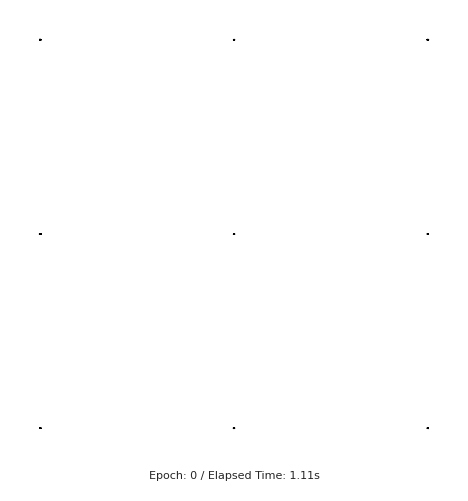

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def generate_and_plot_airfoils(generator, epoch: int = None, num_airfoils=9, scale=0.8, scatter=False, annotate=False, dot_size=20, figsize=(5, 5), linewidth=1.0, time=None):

  def plot_samples(airfoils, scale=0.8, scatter=False, annotate=False, dot_size=20, figsize=(5,5), linewidth=1.0, **kwargs):
      '''
      Plot airfoil coordinates inline.

      Parameters:
      -----------
      airfoils : list of Airfoil objects
          List of Airfoil objects containing the coordinates to be plotted.
      scale : float, optional
          Scaling factor for the plot.
      scatter : bool, optional
          Whether to plot the shapes as a scatter plot.
      annotate : bool, optional
          Whether to annotate the points with their indices.
      dot_size : int, optional
          Size of the dots in the scatter plot.
      figsize : tuple, optional
          Size of the figure (width, height) in inches. Default is (5, 5).
      linewidth : float, optional
          Thickness of the lines when plotting shapes. Default is 1.0.
      **kwargs : dict
          Additional keyword arguments for plotting.
      '''

      # Create a 2D plot with a customizable figure size
      fig, ax = plt.subplots(figsize=figsize)

      # Generate a grid for positioning airfoils
      N = len(airfoils)
      points_per_axis = int(np.sqrt(N))
      bounds = (0., 1.)
      Z = gen_grid(2, points_per_axis, bounds[0], bounds[1])  # Generate a grid

      scale /= points_per_axis

      for (i, z) in enumerate(Z):
          # Extract coordinates from the Airfoil object
          coordinates = airfoils[i].coordinates
          plot_shape(coordinates, z[0], z[1], ax, scale, scatter, dot_size, linewidth, **kwargs)
          if annotate:
              label = '{0}'.format(i+1)
              ax.annotate(label, xy=(z[0], z[1]), size=10)

      plt.xticks([])
      plt.yticks([])
      plt.axis('off')
      plt.axis('equal')
      plt.tight_layout()

      # Add a text box at the bottom to display losses
      if time is not None and epoch is not None:
          loss_text = f"Epoch: {epoch} / Elapsed Time: {time:.2f}s"
          plt.figtext(0.5, 0.01, loss_text, ha="center", fontsize=4)

      plt.savefig('./images/image_at_epoch_{:04d}.png'.format(epoch))
      plt.show()  # Display the plot inline

  def plot_shape(coordinates, x, y, ax, scale, scatter, dot_size, linewidth, **kwargs):
      '''
      Helper function to plot a single shape.

      Parameters:
      -----------
      coordinates : numpy.ndarray
          The coordinates of the shape to be plotted.
      x : float
          The x-coordinate for the shape's position.
      y : float
          The y-coordinate for the shape's position.
      ax : matplotlib.axes.Axes
          The axis to plot on.
      scale : float
          Scaling factor for the plot.
      scatter : bool
          Whether to plot the shapes as a scatter plot.
      dot_size : int
          Size of the dots in the scatter plot.
      linewidth : float
          Thickness of the lines when plotting shapes.
      **kwargs : dict
          Additional keyword arguments for plotting.
      '''
      # Adjust coordinates based on the position (x, y) and scale
      adjusted_coords = coordinates * scale + np.array([x, y])

      if scatter:
          ax.scatter(adjusted_coords[:, 0], adjusted_coords[:, 1], s=dot_size, color='black', **kwargs)
      else:
          ax.plot(adjusted_coords[:, 0], adjusted_coords[:, 1], color='black', linewidth=linewidth, **kwargs)

  def gen_grid(dim, points_per_axis, lower_bound, upper_bound):
      '''
      Generate a grid of points in the specified dimension.

      Parameters:
      -----------
      dim : int
          The dimension of the grid.
      points_per_axis : int
          Number of points per axis.
      lower_bound : float
          Lower bound for the grid.
      upper_bound : float
          Upper bound for the grid.

      Returns:
      --------
      numpy.ndarray
          A grid of points.
      '''
      # Generate a grid of points
      grid = np.mgrid[[slice(lower_bound, upper_bound, points_per_axis*1j) for _ in range(dim)]]
      grid = grid.reshape(dim, -1).T
      return grid

  # Example usage:
  noise = tf.random.normal([num_airfoils, 128])
  generated_coords = generator(noise, training=False)

  # Create a list of Airfoil objects with random coordinates
  airfoils = [Airfoil(coordinates=coords) for coords in generated_coords]

  plot_samples(airfoils, scale=1, scatter=False, annotate=False, figsize=(2.5, 2.5), linewidth=0.5)

test_generator = Generator(128)

generate_and_plot_airfoils(test_generator, time=1.1122, epoch=0, num_airfoils=9, scale=1, scatter=False, annotate=False, figsize=(2.5, 2.5), linewidth=0.5)

In [21]:
from tqdm import tqdm
import time

@tf.function
def train_step(real_data, gen_train_multiple = 1, disc_train_multiple = 1, add_noise=False):
    batch_size = tf.shape(real_data)[0]

    # Generate random latent vectors
    noise = tf.random.normal([batch_size, latent_dim])

    for _ in range(gen_train_multiple):
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_data = generator(noise, training=True)

        fake_output = discriminator(fake_data, training=True)

        gen_loss = generator_loss(fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    for _ in range(disc_train_multiple):
      with tf.GradientTape() as disc_tape:
        # Generate fake data (again, since the generator was updated)
        fake_data = generator(noise, training=True)

        # Discriminator predictions on real and fake data
        if add_noise:
          # Add noise to discriminator data
          real_data_noisy = real_data + tf.random.normal(tf.shape(real_data), mean=0.0, stddev=0.1)
          fake_data_noisy = fake_data + tf.random.normal(tf.shape(fake_data), mean=0.0, stddev=0.1)
          real_output = discriminator(real_data_noisy, training=True)
          fake_output = discriminator(fake_data_noisy, training=True)
        else:
          real_output = discriminator(real_data, training=True)
          fake_output = discriminator(fake_data, training=True)

        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(fake_data, training=True)

        # Discriminator loss
        disc_loss, disc_real_loss, disc_fake_loss = discriminator_loss(real_output, fake_output)

      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss, disc_real_loss, disc_fake_loss, gen_loss

def train(dataset, epochs):
  elapsed_time = 0

  # Training loop
  for epoch in range(epochs):
      print(f"\nEpoch {epoch + 1}/{epochs}")
      start_time = time.time()

      # Initialize epoch losses
      epoch_disc_loss = 0.0
      epoch_gen_loss = 0.0
      epoch_real_loss = 0.0
      epoch_fake_loss = 0.0
      num_batches = 0

      # Iterate over the dataset with a progress bar
      for batch in tqdm(dataset, desc="Training"):
          # Perform a training step
          disc_loss, disc_real_loss, disc_fake_loss, gen_loss = train_step(batch, gen_train_multiple=1, disc_train_multiple=1, add_noise=False)

          # Accumulate losses
          epoch_disc_loss += disc_loss.numpy()
          epoch_gen_loss += gen_loss.numpy()
          epoch_real_loss += disc_real_loss.numpy()
          epoch_fake_loss += disc_fake_loss.numpy()
          num_batches += 1

      # Calculate average losses for the epoch
      avg_disc_loss = epoch_disc_loss / num_batches
      avg_gen_loss = epoch_gen_loss / num_batches
      avg_real_loss = epoch_real_loss / num_batches
      avg_fake_loss = epoch_fake_loss / num_batches

      # Print epoch results
      epoch_time = time.time() - start_time
      elapsed_time = elapsed_time + epoch_time
      print(f"Discriminator Loss: {avg_disc_loss:.4f}, Generator Loss: {avg_gen_loss:.4f}, Time: {epoch_time:.2f}s")

      print("Generating and plotting airfoils...")
      # Produce images for the GIF as you go
      # display.clear_output(wait=True)
      generate_and_plot_airfoils(generator, time=elapsed_time, epoch=epoch + 1, num_airfoils=9, scale=1, scatter=False, annotate=False, figsize=(2.5, 2.5), linewidth=0.5)

      # Save model checkpoints every 5 epochs
      if (epoch + 1) % 5 == 0:
          print("Saving model checkpoints...")
          # Save the generator
          generator.save(f"./models/generator_model_{epoch+1}.keras")

          # Save the discriminator
          discriminator.save(f"./models/discriminator_model_{epoch+1}.keras")

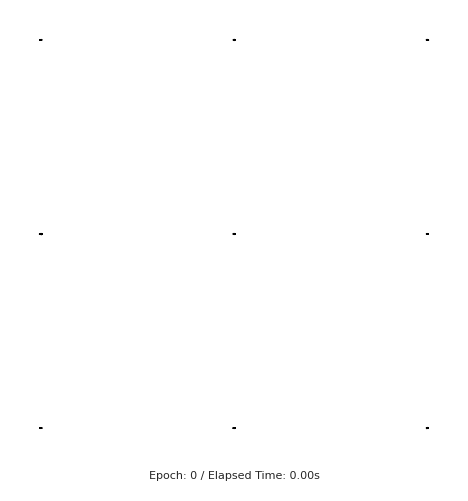


Epoch 1/100


Training: 100%|██████████| 68/68 [01:21<00:00,  1.19s/it]


Discriminator Loss: 0.6948, Generator Loss: 2.2856, Time: 81.14s
Generating and plotting airfoils...


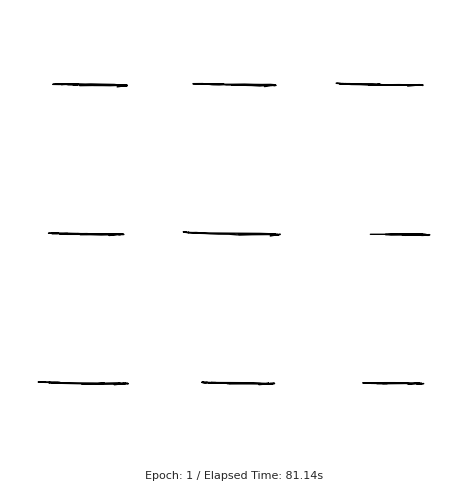


Epoch 2/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s]


Discriminator Loss: 1.2532, Generator Loss: 1.1303, Time: 65.50s
Generating and plotting airfoils...


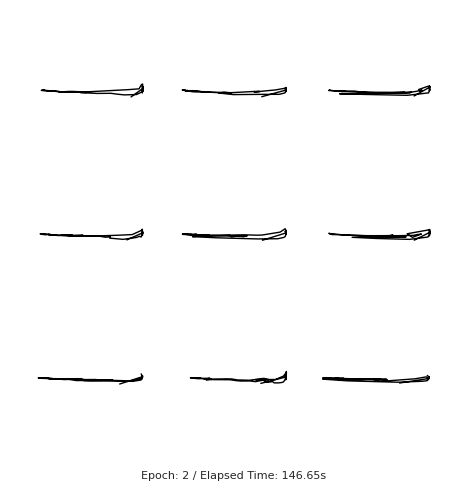


Epoch 3/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s]


Discriminator Loss: 1.2304, Generator Loss: 0.9146, Time: 65.58s
Generating and plotting airfoils...


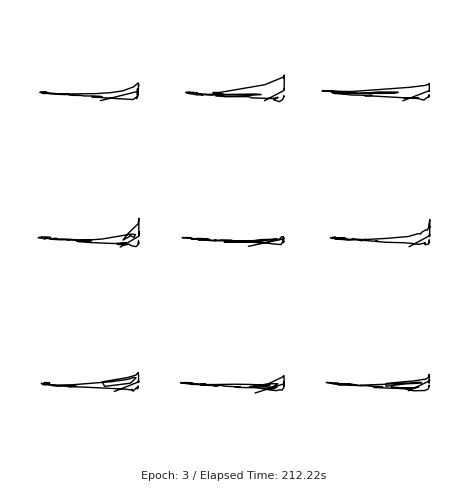


Epoch 4/100


Training: 100%|██████████| 68/68 [01:04<00:00,  1.05it/s]


Discriminator Loss: 1.3614, Generator Loss: 0.8052, Time: 64.54s
Generating and plotting airfoils...


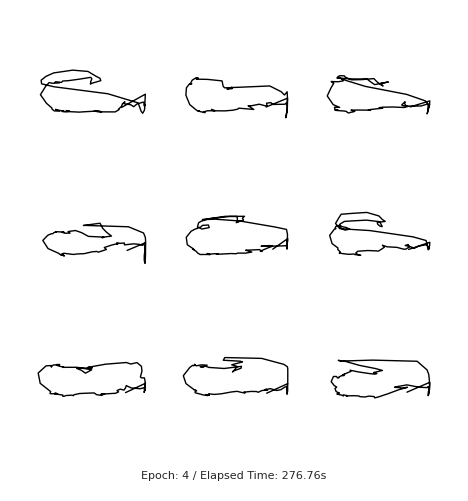


Epoch 5/100


Training: 100%|██████████| 68/68 [01:04<00:00,  1.05it/s]


Discriminator Loss: 1.3338, Generator Loss: 0.7917, Time: 64.60s
Generating and plotting airfoils...


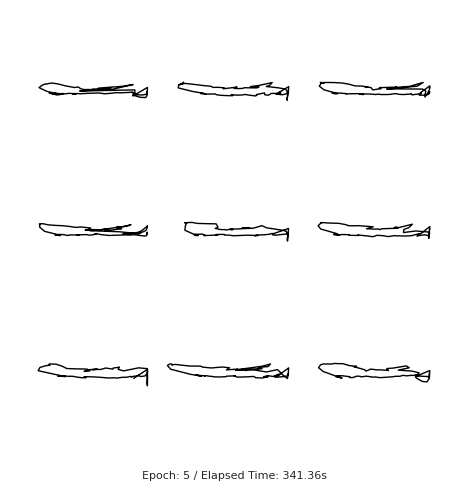

Saving model checkpoints...

Epoch 6/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3414, Generator Loss: 0.8048, Time: 66.04s
Generating and plotting airfoils...


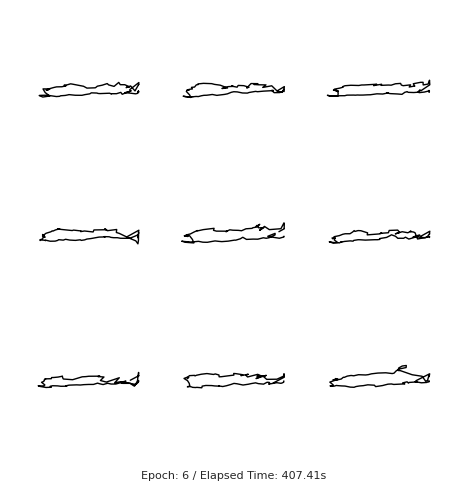


Epoch 7/100


Training: 100%|██████████| 68/68 [01:03<00:00,  1.07it/s]


Discriminator Loss: 1.3447, Generator Loss: 0.8272, Time: 63.57s
Generating and plotting airfoils...


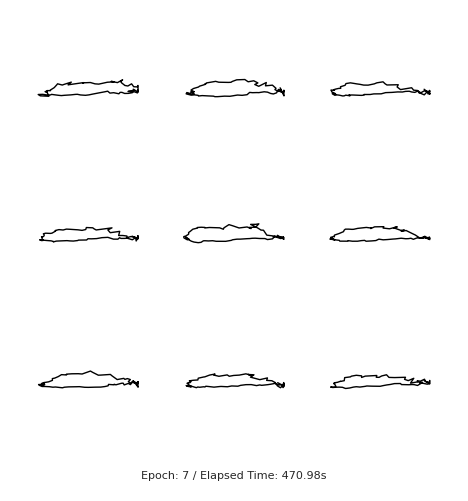


Epoch 8/100


Training: 100%|██████████| 68/68 [01:04<00:00,  1.06it/s]


Discriminator Loss: 1.3553, Generator Loss: 0.8174, Time: 64.39s
Generating and plotting airfoils...


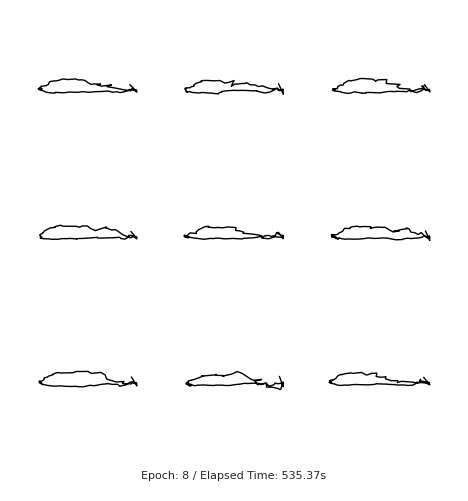


Epoch 9/100


Training: 100%|██████████| 68/68 [01:04<00:00,  1.05it/s]


Discriminator Loss: 1.3543, Generator Loss: 0.8390, Time: 64.90s
Generating and plotting airfoils...


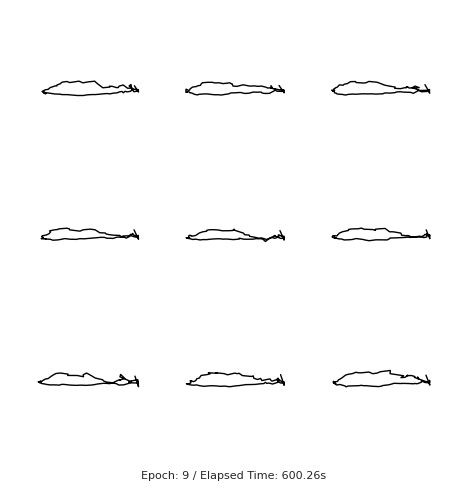


Epoch 10/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3531, Generator Loss: 0.8490, Time: 66.25s
Generating and plotting airfoils...


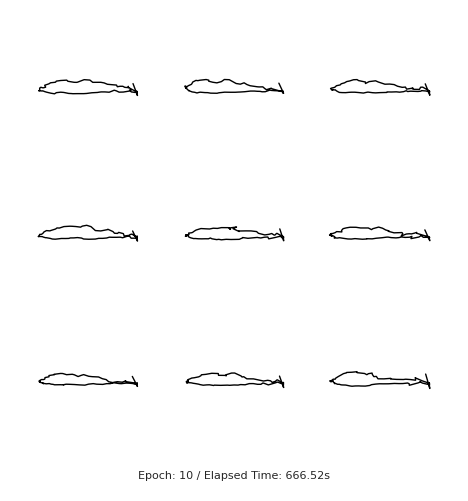

Saving model checkpoints...

Epoch 11/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s]


Discriminator Loss: 1.3608, Generator Loss: 0.8718, Time: 66.99s
Generating and plotting airfoils...


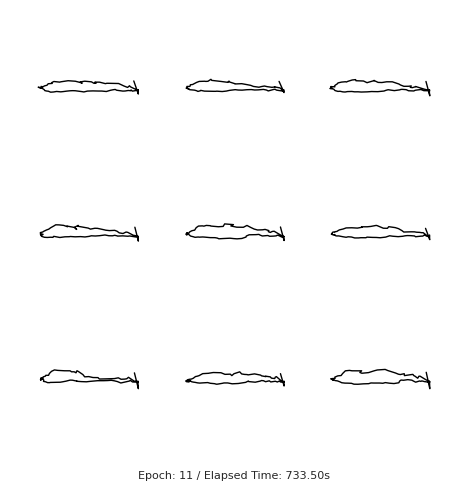


Epoch 12/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s]


Discriminator Loss: 1.3490, Generator Loss: 0.8770, Time: 65.30s
Generating and plotting airfoils...


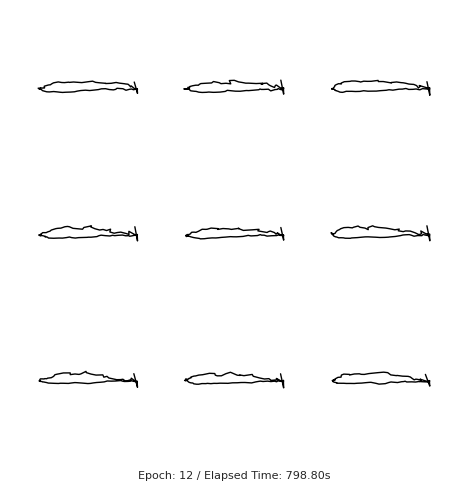


Epoch 13/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s]


Discriminator Loss: 1.3555, Generator Loss: 0.8652, Time: 66.70s
Generating and plotting airfoils...


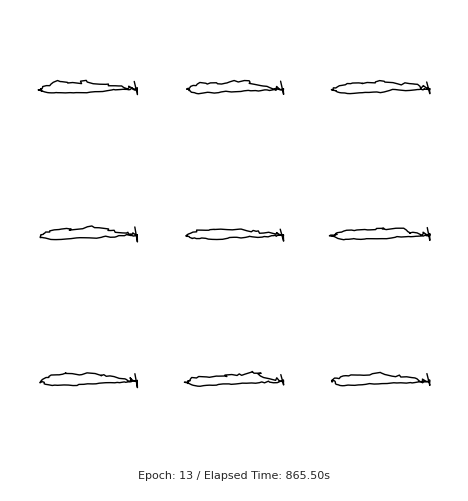


Epoch 14/100


Training: 100%|██████████| 68/68 [01:04<00:00,  1.06it/s]


Discriminator Loss: 1.3458, Generator Loss: 0.8877, Time: 64.02s
Generating and plotting airfoils...


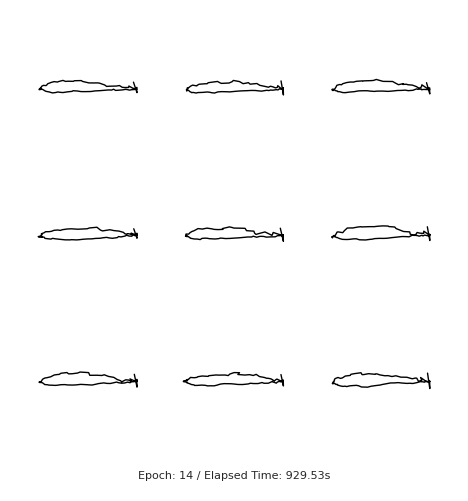


Epoch 15/100


Training: 100%|██████████| 68/68 [01:03<00:00,  1.07it/s]


Discriminator Loss: 1.3484, Generator Loss: 0.9361, Time: 63.51s
Generating and plotting airfoils...


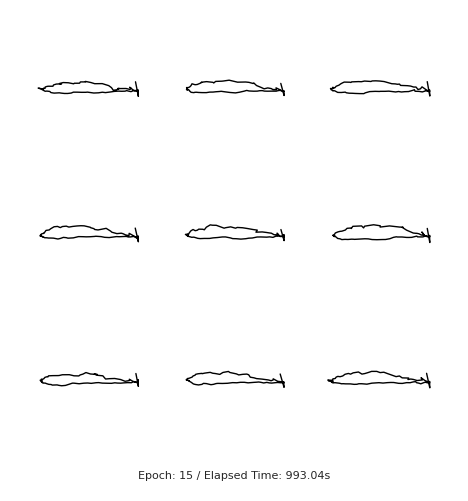

Saving model checkpoints...

Epoch 16/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s]


Discriminator Loss: 1.3529, Generator Loss: 0.9030, Time: 65.11s
Generating and plotting airfoils...


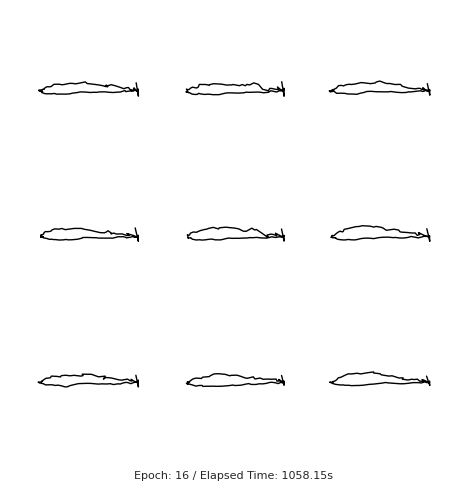


Epoch 17/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3624, Generator Loss: 0.8792, Time: 66.28s
Generating and plotting airfoils...


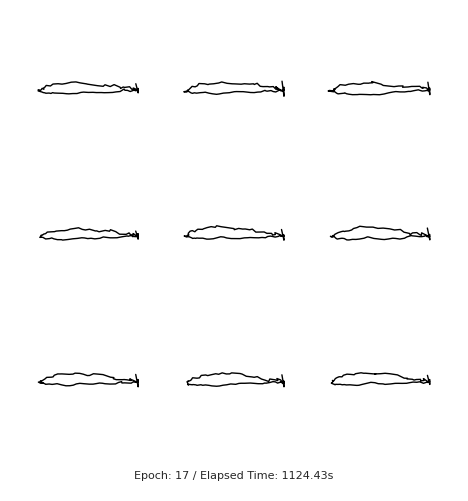


Epoch 18/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s]


Discriminator Loss: 1.3530, Generator Loss: 0.8945, Time: 65.38s
Generating and plotting airfoils...


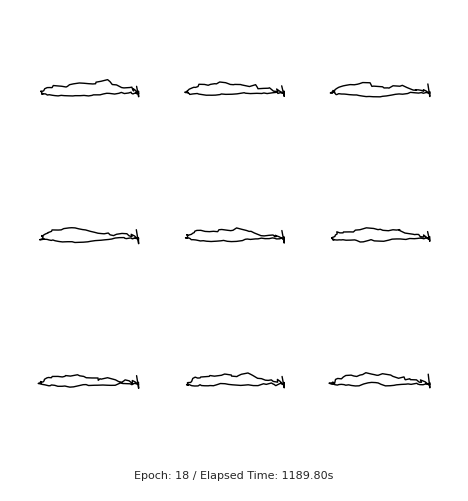


Epoch 19/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s]


Discriminator Loss: 1.3480, Generator Loss: 0.9108, Time: 65.35s
Generating and plotting airfoils...


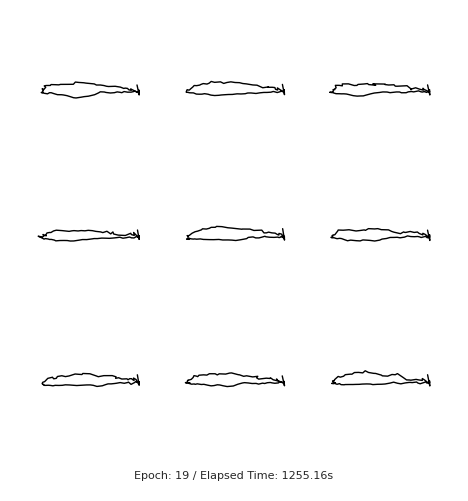


Epoch 20/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s]


Discriminator Loss: 1.3509, Generator Loss: 0.9123, Time: 66.93s
Generating and plotting airfoils...


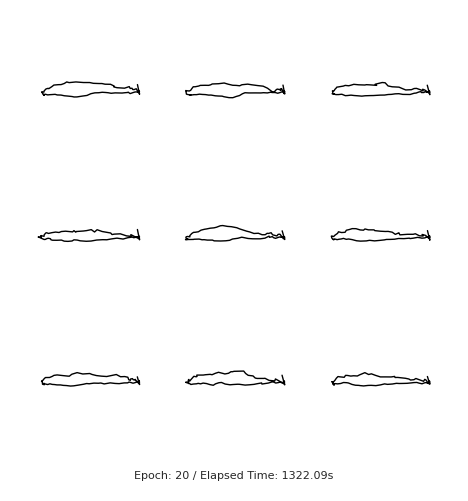

Saving model checkpoints...

Epoch 21/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.03it/s]


Discriminator Loss: 1.3579, Generator Loss: 0.9059, Time: 66.00s
Generating and plotting airfoils...


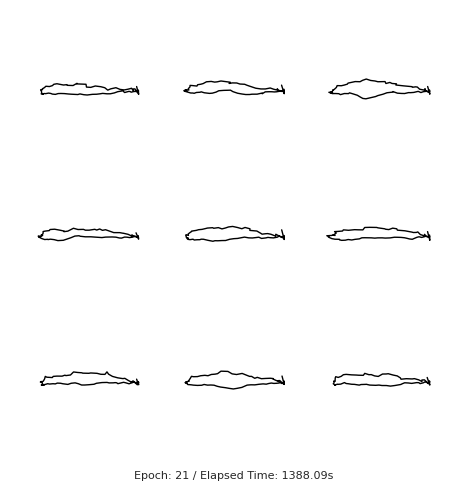


Epoch 22/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3757, Generator Loss: 0.9229, Time: 66.02s
Generating and plotting airfoils...


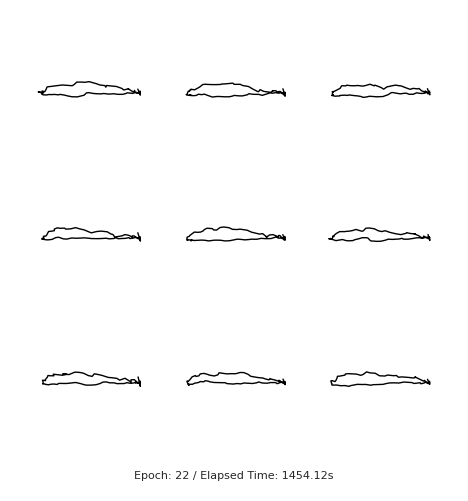


Epoch 23/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s]


Discriminator Loss: 1.3664, Generator Loss: 0.8893, Time: 65.10s
Generating and plotting airfoils...


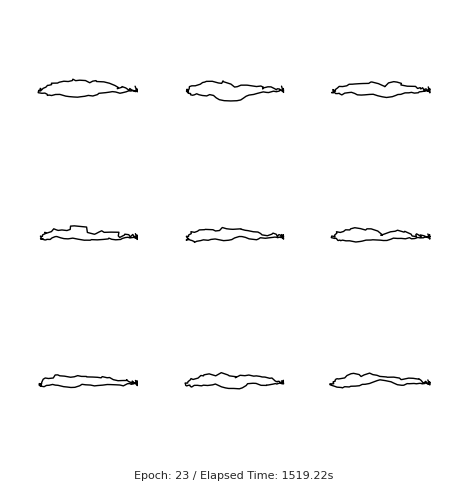


Epoch 24/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s]


Discriminator Loss: 1.3761, Generator Loss: 0.8890, Time: 65.33s
Generating and plotting airfoils...


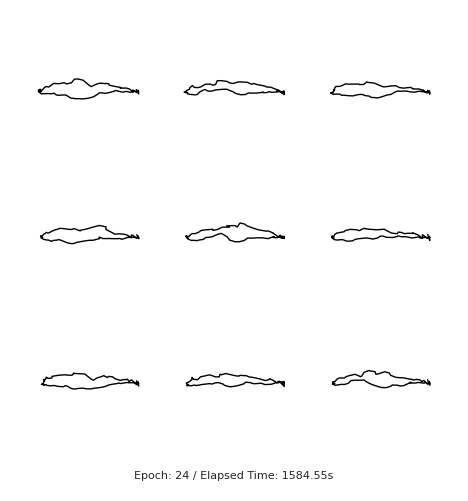


Epoch 25/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3626, Generator Loss: 0.8622, Time: 66.15s
Generating and plotting airfoils...


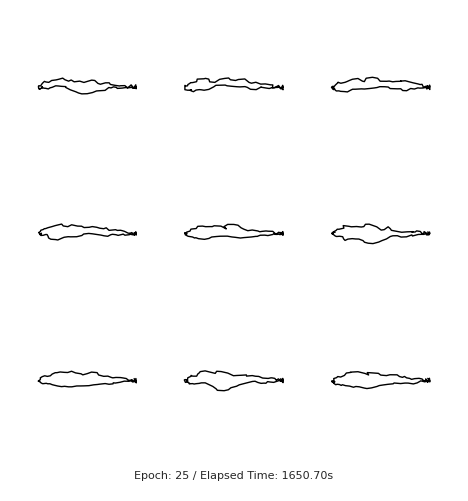

Saving model checkpoints...

Epoch 26/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s]


Discriminator Loss: 1.3780, Generator Loss: 0.8604, Time: 66.68s
Generating and plotting airfoils...


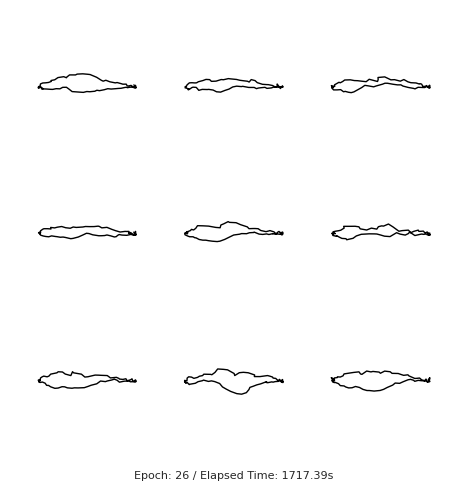


Epoch 27/100


Training: 100%|██████████| 68/68 [01:08<00:00,  1.01s/it]


Discriminator Loss: 1.3703, Generator Loss: 0.8523, Time: 68.60s
Generating and plotting airfoils...


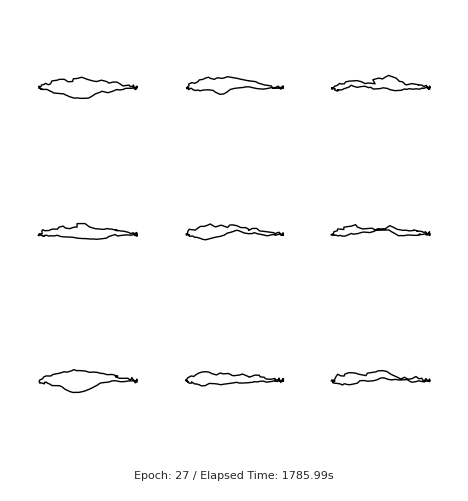


Epoch 28/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s]


Discriminator Loss: 1.3789, Generator Loss: 0.8909, Time: 66.76s
Generating and plotting airfoils...


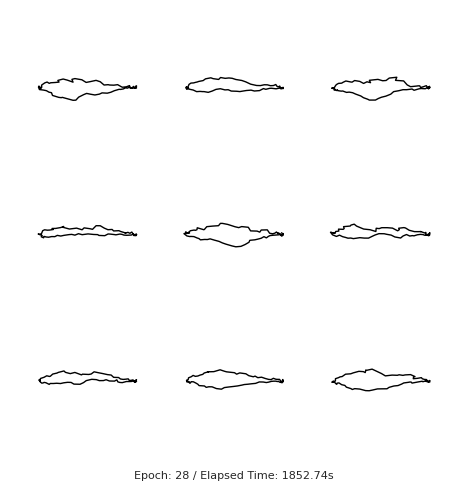


Epoch 29/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3680, Generator Loss: 0.8781, Time: 66.34s
Generating and plotting airfoils...


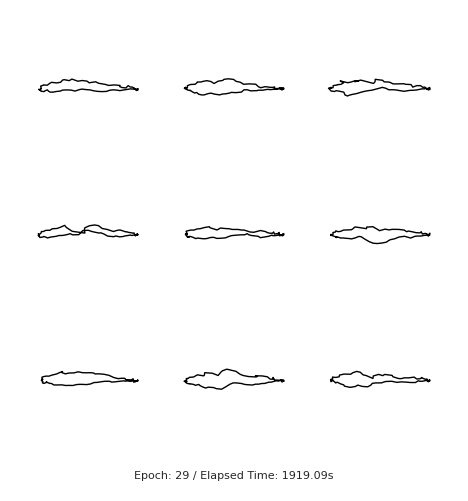


Epoch 30/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s]


Discriminator Loss: 1.3675, Generator Loss: 0.8588, Time: 66.58s
Generating and plotting airfoils...


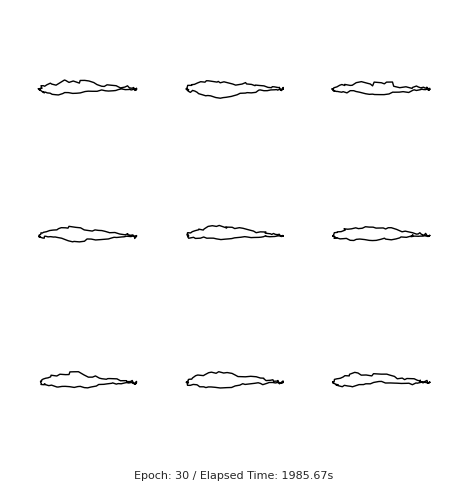

Saving model checkpoints...

Epoch 31/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3745, Generator Loss: 0.8645, Time: 67.68s
Generating and plotting airfoils...


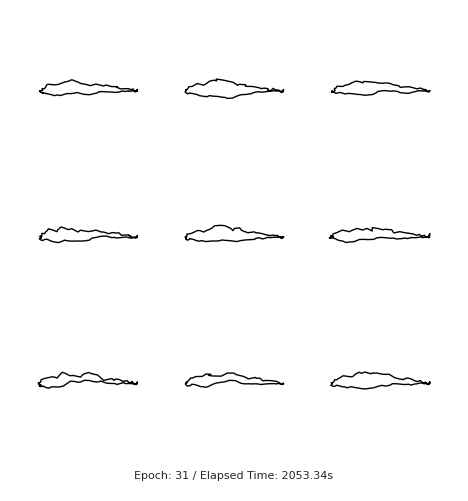


Epoch 32/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.03it/s]


Discriminator Loss: 1.3739, Generator Loss: 0.8558, Time: 65.75s
Generating and plotting airfoils...


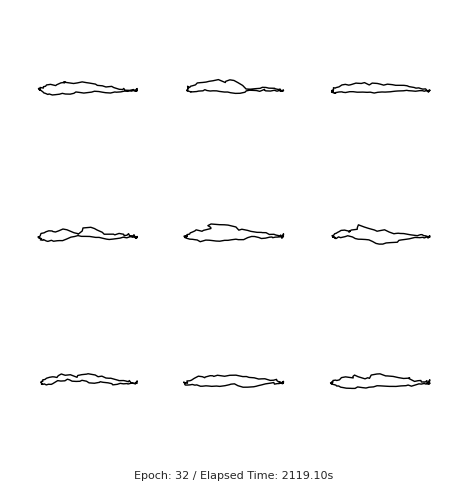


Epoch 33/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3740, Generator Loss: 0.8616, Time: 66.19s
Generating and plotting airfoils...


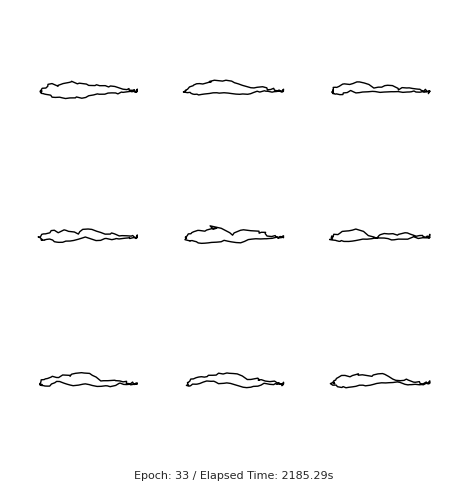


Epoch 34/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


Discriminator Loss: 1.3745, Generator Loss: 0.8672, Time: 67.33s
Generating and plotting airfoils...


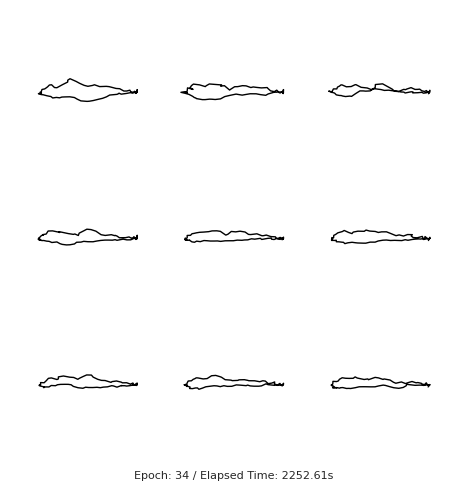


Epoch 35/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s]


Discriminator Loss: 1.3767, Generator Loss: 0.8499, Time: 65.46s
Generating and plotting airfoils...


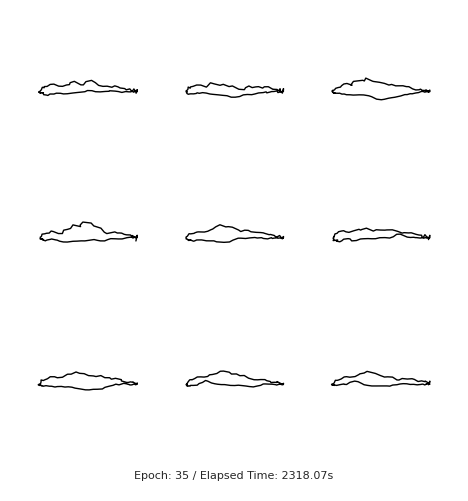

Saving model checkpoints...

Epoch 36/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.05it/s]


Discriminator Loss: 1.3805, Generator Loss: 0.8336, Time: 65.06s
Generating and plotting airfoils...


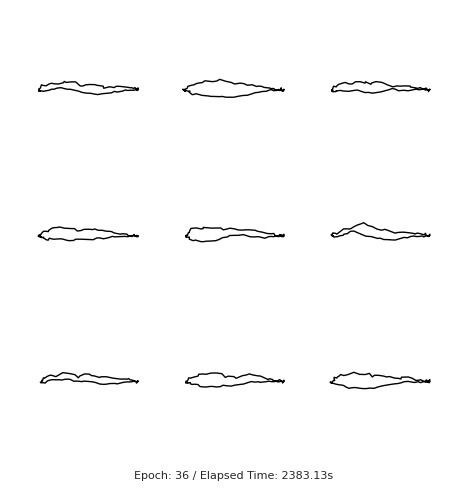


Epoch 37/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3782, Generator Loss: 0.8155, Time: 66.32s
Generating and plotting airfoils...


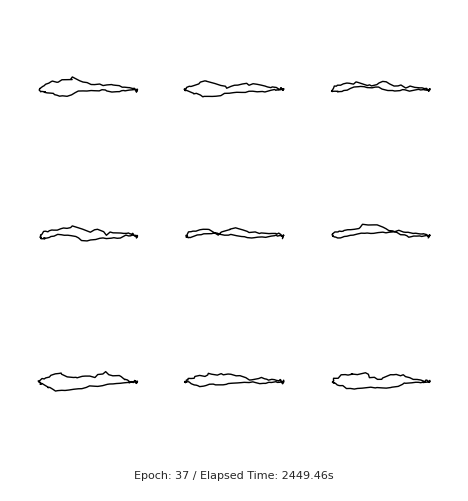


Epoch 38/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


Discriminator Loss: 1.3812, Generator Loss: 0.8288, Time: 67.25s
Generating and plotting airfoils...


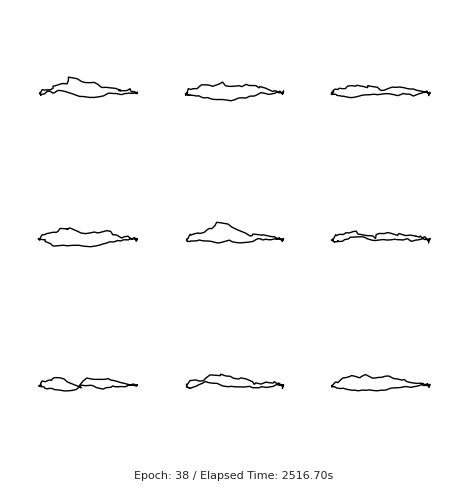


Epoch 39/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.03it/s]


Discriminator Loss: 1.3789, Generator Loss: 0.8121, Time: 65.94s
Generating and plotting airfoils...


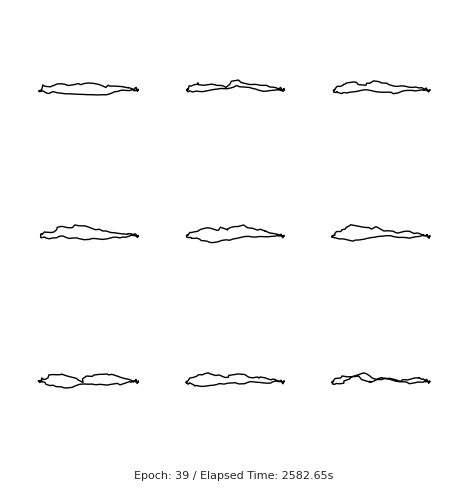


Epoch 40/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3804, Generator Loss: 0.7997, Time: 66.20s
Generating and plotting airfoils...


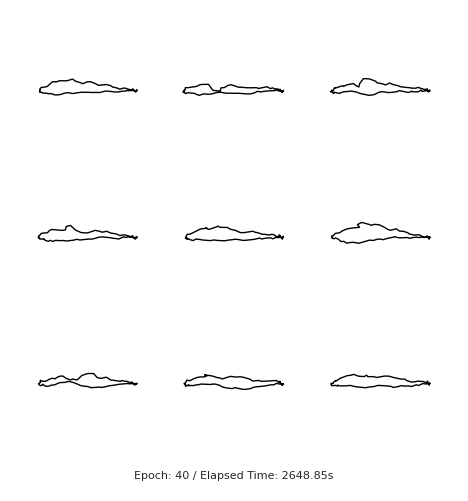

Saving model checkpoints...

Epoch 41/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3849, Generator Loss: 0.8163, Time: 67.88s
Generating and plotting airfoils...


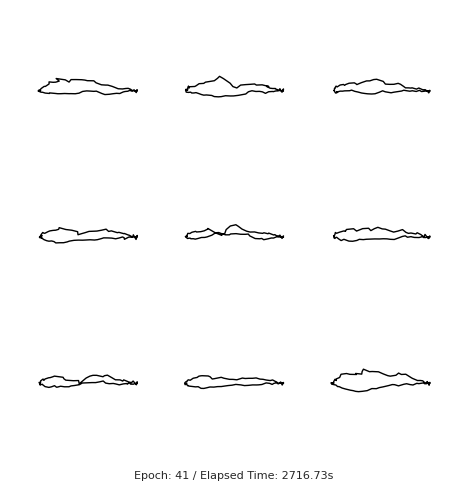


Epoch 42/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3820, Generator Loss: 0.7866, Time: 66.01s
Generating and plotting airfoils...


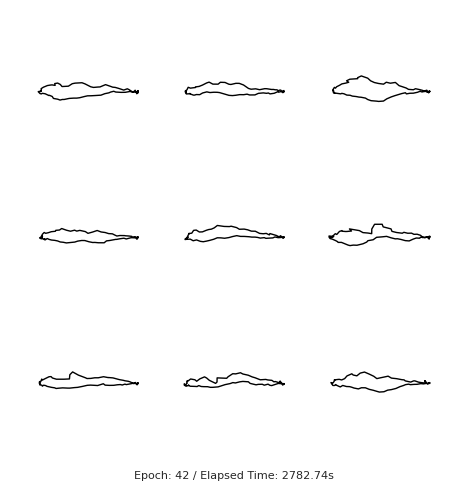


Epoch 43/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.03it/s]


Discriminator Loss: 1.3815, Generator Loss: 0.7926, Time: 65.80s
Generating and plotting airfoils...


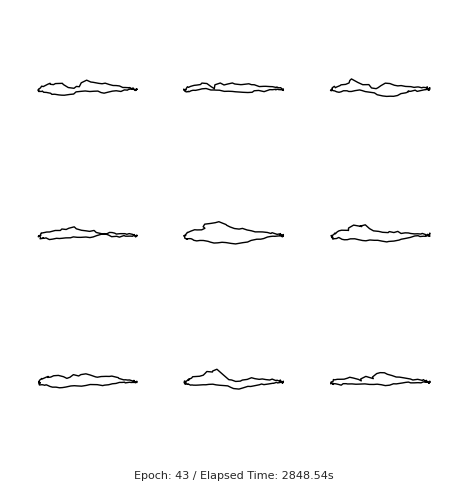


Epoch 44/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3812, Generator Loss: 0.7943, Time: 66.08s
Generating and plotting airfoils...


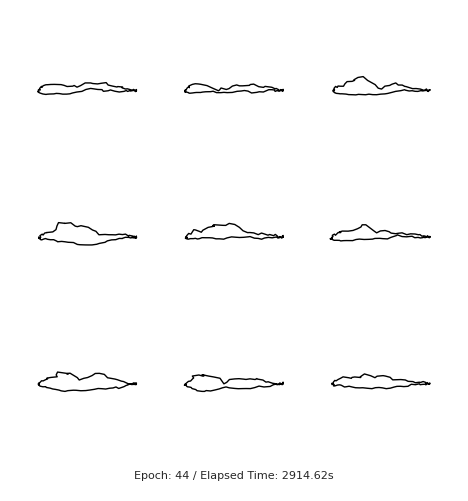


Epoch 45/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


Discriminator Loss: 1.3858, Generator Loss: 0.8041, Time: 67.58s
Generating and plotting airfoils...


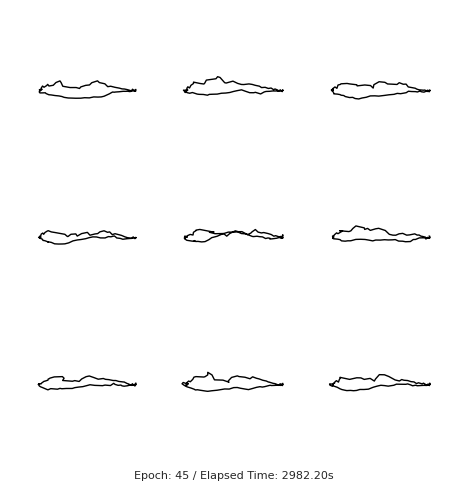

Saving model checkpoints...

Epoch 46/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3797, Generator Loss: 0.7935, Time: 66.10s
Generating and plotting airfoils...


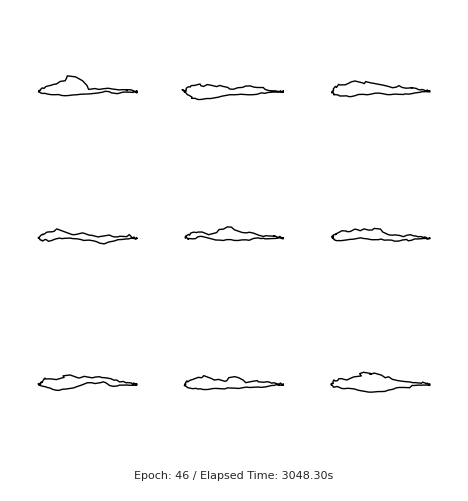


Epoch 47/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3901, Generator Loss: 0.7717, Time: 66.15s
Generating and plotting airfoils...


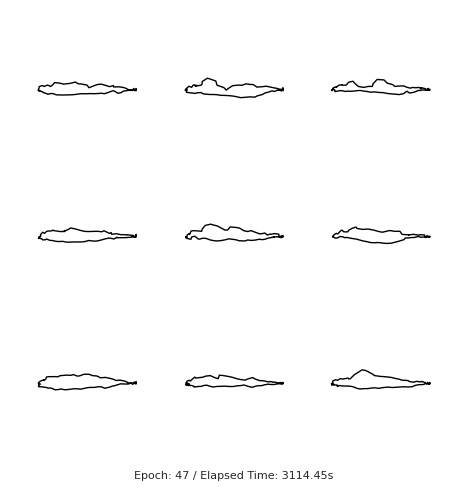


Epoch 48/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3816, Generator Loss: 0.7318, Time: 66.16s
Generating and plotting airfoils...


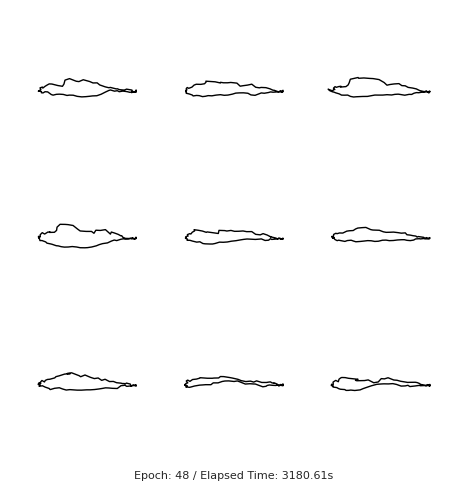


Epoch 49/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.03it/s]


Discriminator Loss: 1.3846, Generator Loss: 0.7475, Time: 65.74s
Generating and plotting airfoils...


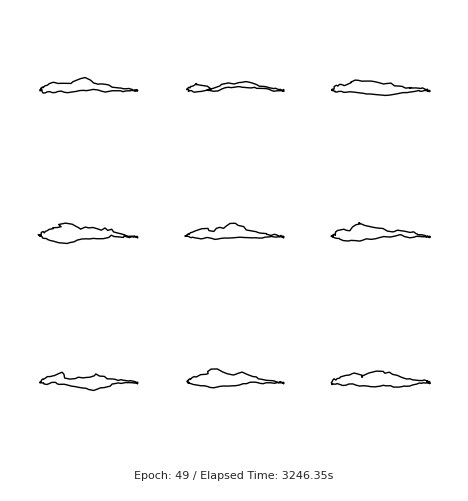


Epoch 50/100


Training: 100%|██████████| 68/68 [01:05<00:00,  1.03it/s]


Discriminator Loss: 1.3822, Generator Loss: 0.7478, Time: 65.98s
Generating and plotting airfoils...


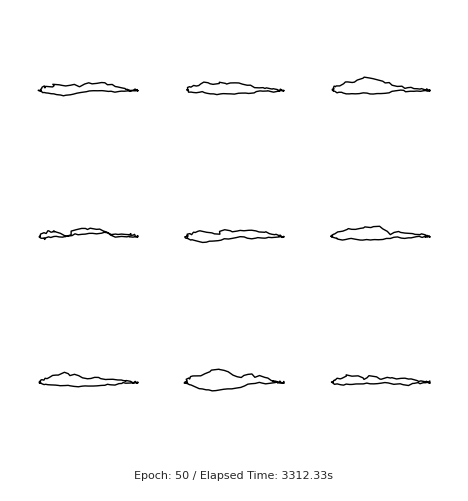

Saving model checkpoints...

Epoch 51/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


Discriminator Loss: 1.3866, Generator Loss: 0.7734, Time: 67.41s
Generating and plotting airfoils...


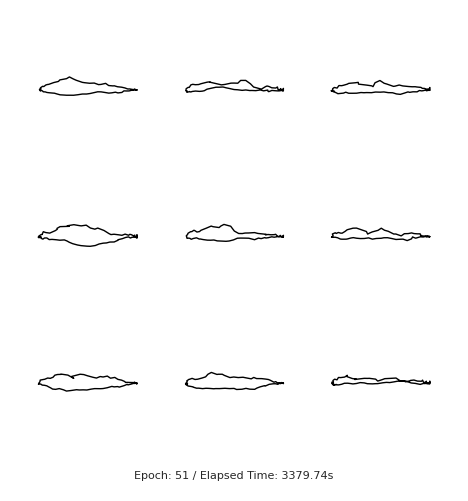


Epoch 52/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s]


Discriminator Loss: 1.3843, Generator Loss: 0.7400, Time: 66.39s
Generating and plotting airfoils...


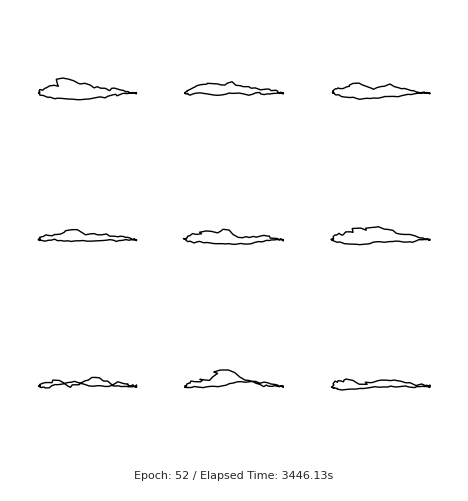


Epoch 53/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s]


Discriminator Loss: 1.3841, Generator Loss: 0.7571, Time: 66.68s
Generating and plotting airfoils...


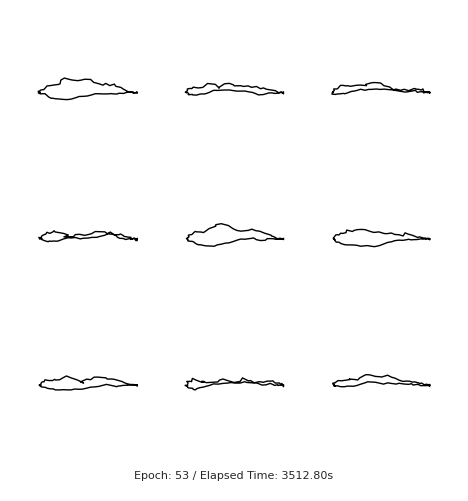


Epoch 54/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3822, Generator Loss: 0.7585, Time: 66.29s
Generating and plotting airfoils...


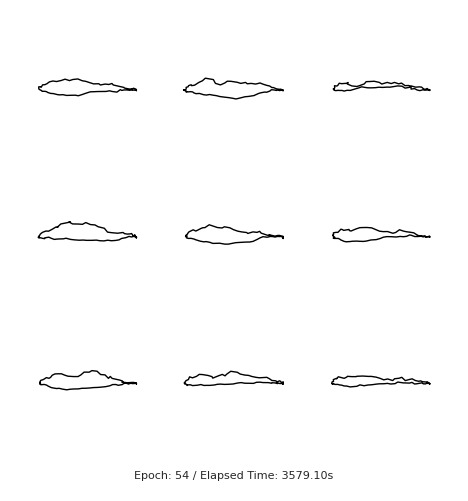


Epoch 55/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3844, Generator Loss: 0.7536, Time: 67.80s
Generating and plotting airfoils...


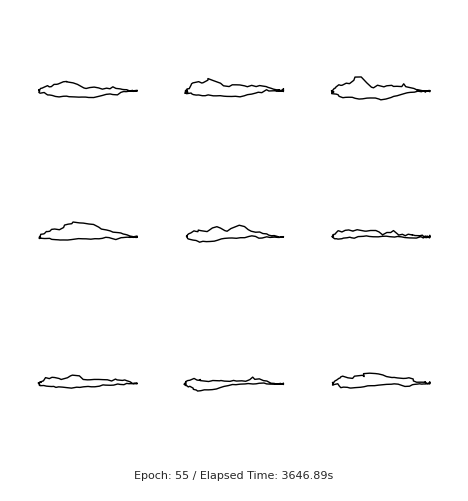

Saving model checkpoints...

Epoch 56/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


Discriminator Loss: 1.3886, Generator Loss: 0.7705, Time: 66.17s
Generating and plotting airfoils...


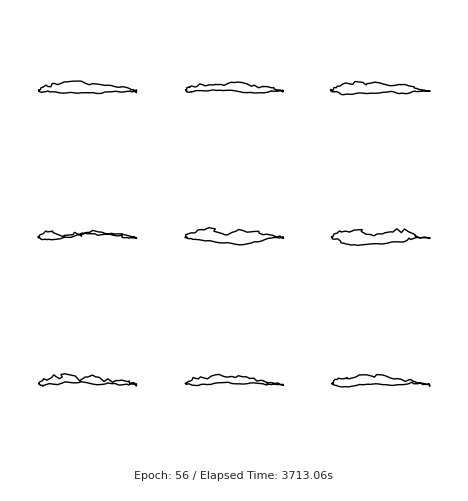


Epoch 57/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s]


Discriminator Loss: 1.3828, Generator Loss: 0.7304, Time: 66.67s
Generating and plotting airfoils...


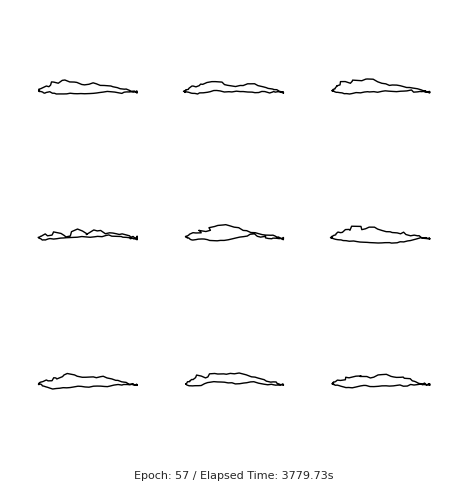


Epoch 58/100


Training: 100%|██████████| 68/68 [01:08<00:00,  1.00s/it]


Discriminator Loss: 1.3842, Generator Loss: 0.7482, Time: 68.03s
Generating and plotting airfoils...


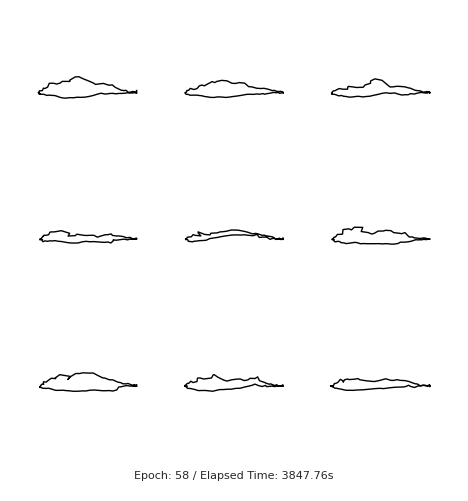


Epoch 59/100


Training: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s]


Discriminator Loss: 1.3854, Generator Loss: 0.7619, Time: 66.78s
Generating and plotting airfoils...


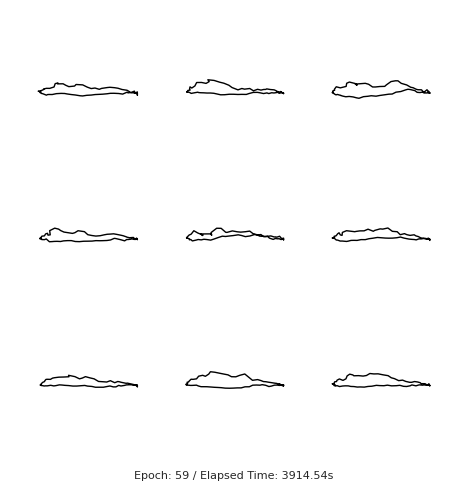


Epoch 60/100


Training: 100%|██████████| 68/68 [01:10<00:00,  1.03s/it]


Discriminator Loss: 1.3818, Generator Loss: 0.7274, Time: 70.33s
Generating and plotting airfoils...


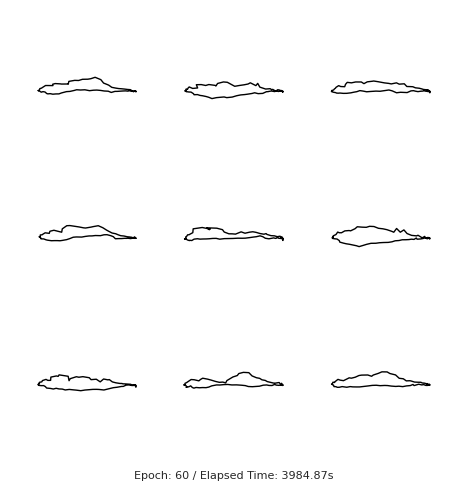

Saving model checkpoints...

Epoch 61/100


Training: 100%|██████████| 68/68 [01:08<00:00,  1.01s/it]


Discriminator Loss: 1.3842, Generator Loss: 0.7515, Time: 68.76s
Generating and plotting airfoils...


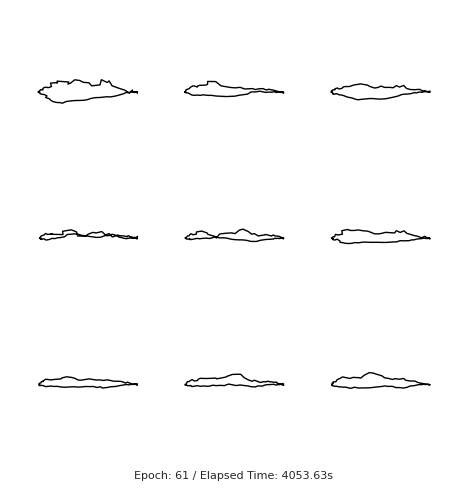


Epoch 62/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3847, Generator Loss: 0.7333, Time: 67.72s
Generating and plotting airfoils...


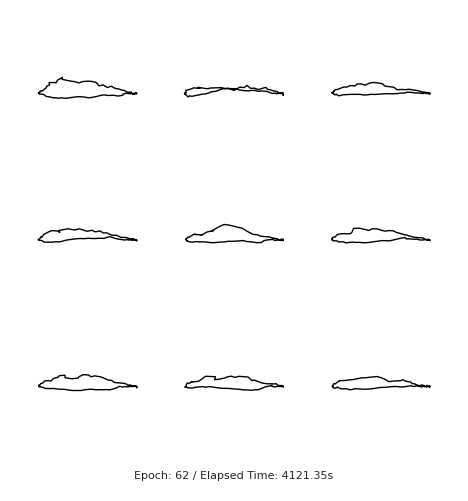


Epoch 63/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


Discriminator Loss: 1.3845, Generator Loss: 0.7230, Time: 67.17s
Generating and plotting airfoils...


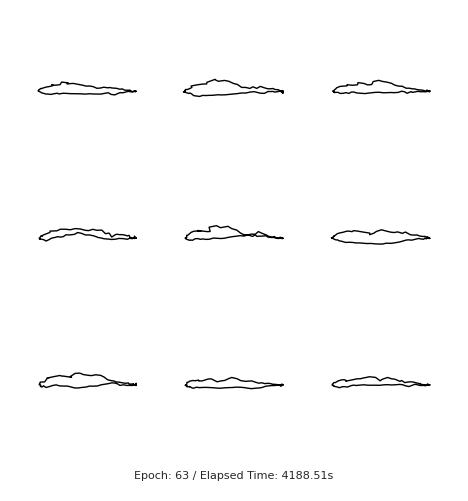


Epoch 64/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3887, Generator Loss: 0.7385, Time: 67.76s
Generating and plotting airfoils...


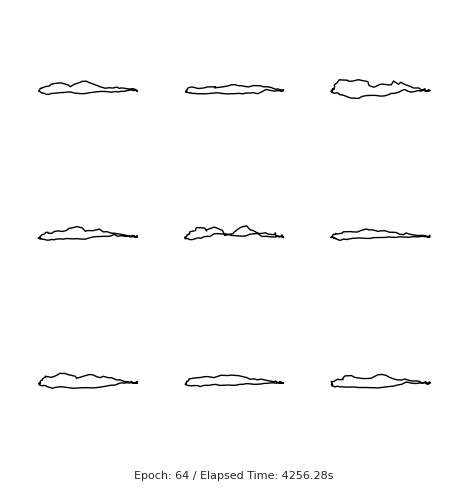


Epoch 65/100


Training: 100%|██████████| 68/68 [01:08<00:00,  1.01s/it]


Discriminator Loss: 1.3840, Generator Loss: 0.7210, Time: 68.77s
Generating and plotting airfoils...


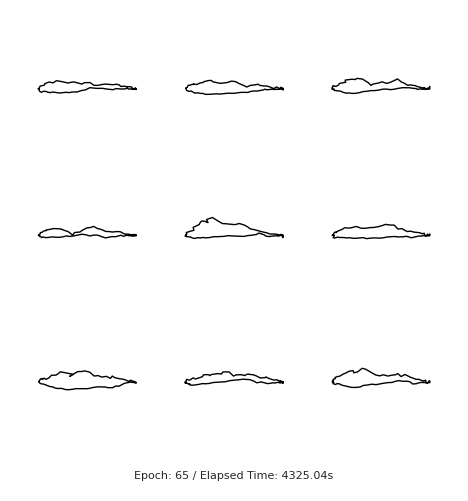

Saving model checkpoints...

Epoch 66/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


Discriminator Loss: 1.3842, Generator Loss: 0.7224, Time: 67.17s
Generating and plotting airfoils...


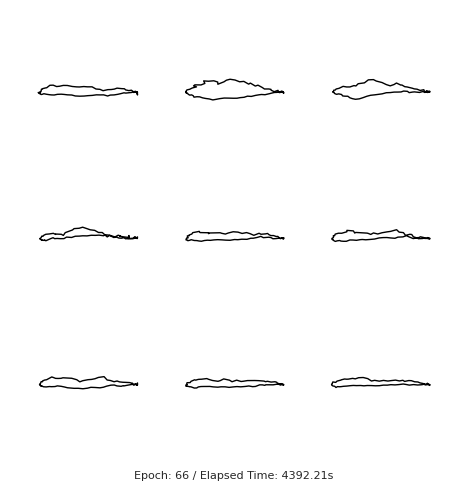


Epoch 67/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3870, Generator Loss: 0.7217, Time: 67.79s
Generating and plotting airfoils...


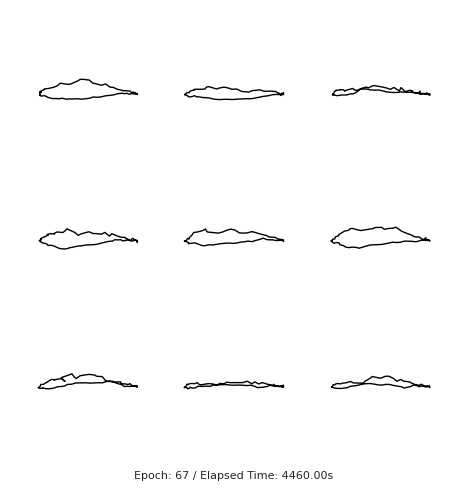


Epoch 68/100


Training: 100%|██████████| 68/68 [01:09<00:00,  1.02s/it]


Discriminator Loss: 1.3892, Generator Loss: 0.7571, Time: 69.31s
Generating and plotting airfoils...


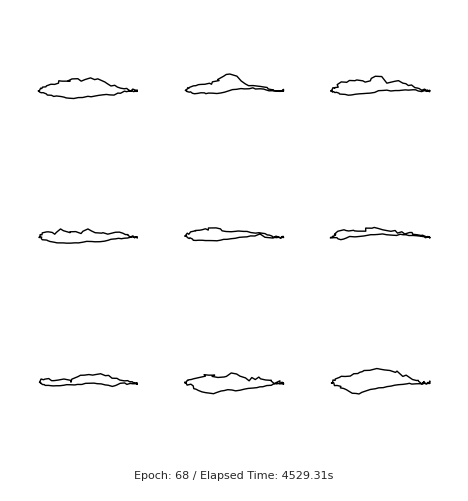


Epoch 69/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3882, Generator Loss: 0.7338, Time: 67.94s
Generating and plotting airfoils...


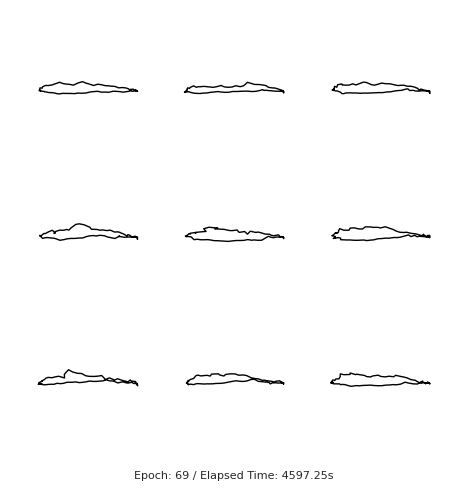


Epoch 70/100


Training: 100%|██████████| 68/68 [01:08<00:00,  1.00s/it]


Discriminator Loss: 1.3851, Generator Loss: 0.7092, Time: 68.02s
Generating and plotting airfoils...


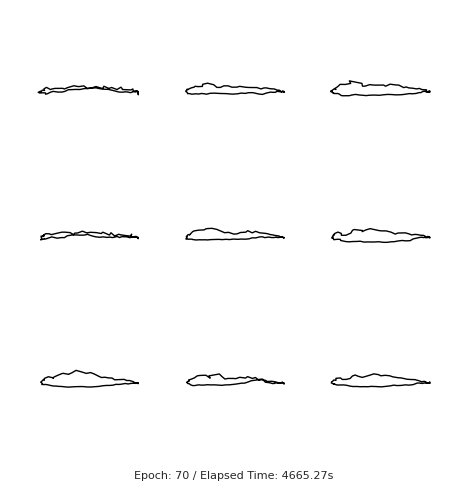

Saving model checkpoints...

Epoch 71/100


Training: 100%|██████████| 68/68 [01:09<00:00,  1.02s/it]


Discriminator Loss: 1.3868, Generator Loss: 0.7149, Time: 69.61s
Generating and plotting airfoils...


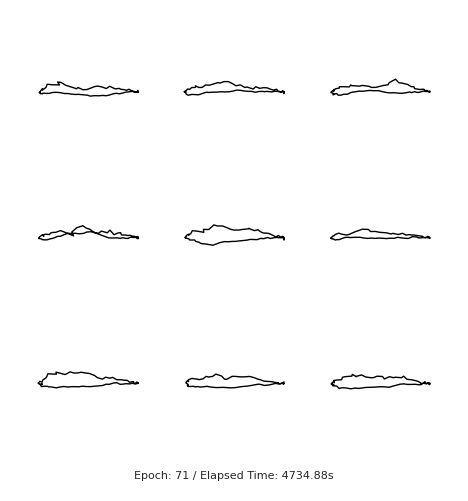


Epoch 72/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


Discriminator Loss: 1.3870, Generator Loss: 0.7212, Time: 67.39s
Generating and plotting airfoils...


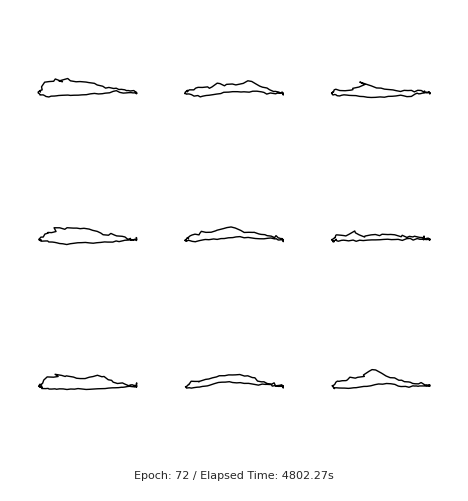


Epoch 73/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3873, Generator Loss: 0.7264, Time: 67.99s
Generating and plotting airfoils...


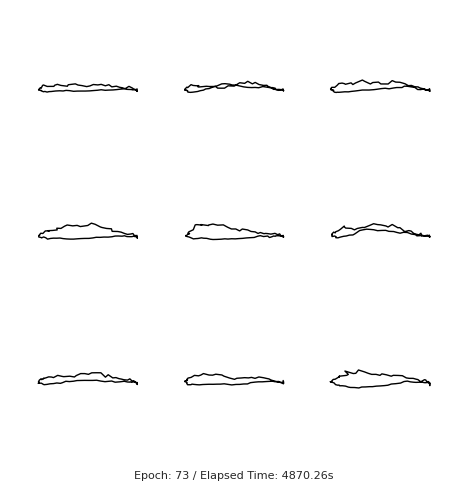


Epoch 74/100


Training: 100%|██████████| 68/68 [01:09<00:00,  1.02s/it]


Discriminator Loss: 1.3866, Generator Loss: 0.7219, Time: 69.19s
Generating and plotting airfoils...


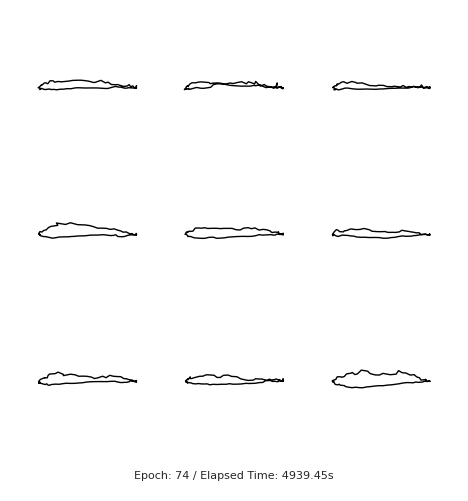


Epoch 75/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3871, Generator Loss: 0.7249, Time: 67.85s
Generating and plotting airfoils...


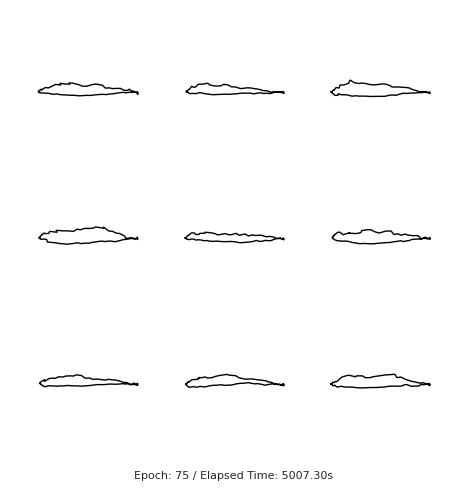

Saving model checkpoints...

Epoch 76/100


Training: 100%|██████████| 68/68 [01:08<00:00,  1.01s/it]


Discriminator Loss: 1.3857, Generator Loss: 0.7165, Time: 68.50s
Generating and plotting airfoils...


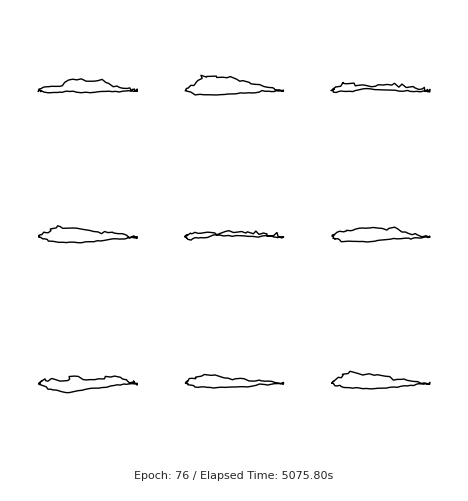


Epoch 77/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3876, Generator Loss: 0.7175, Time: 67.70s
Generating and plotting airfoils...


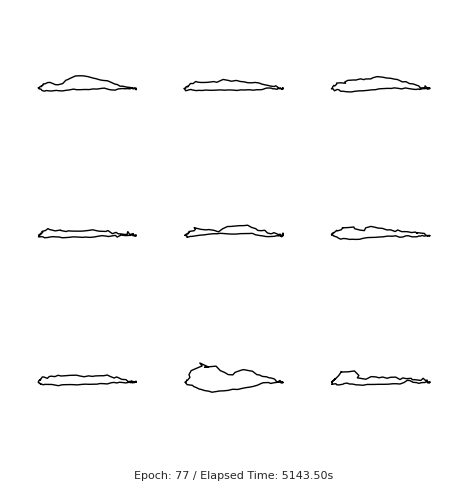


Epoch 78/100


Training: 100%|██████████| 68/68 [01:09<00:00,  1.02s/it]


Discriminator Loss: 1.3862, Generator Loss: 0.7149, Time: 69.16s
Generating and plotting airfoils...


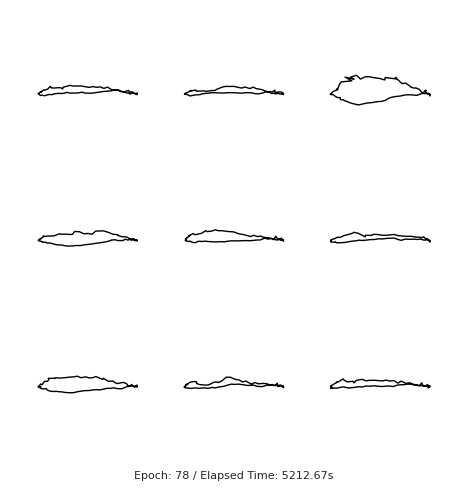


Epoch 79/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


Discriminator Loss: 1.3890, Generator Loss: 0.7304, Time: 67.45s
Generating and plotting airfoils...


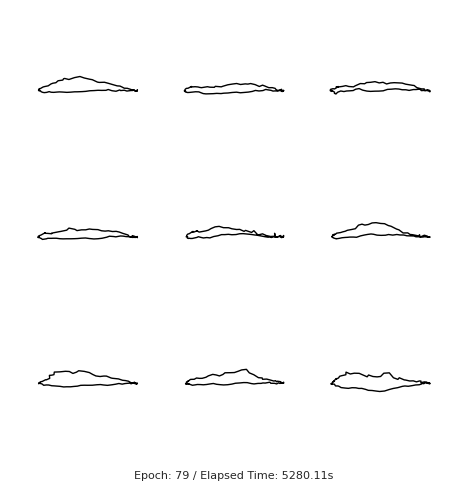


Epoch 80/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


Discriminator Loss: 1.3887, Generator Loss: 0.7165, Time: 67.54s
Generating and plotting airfoils...


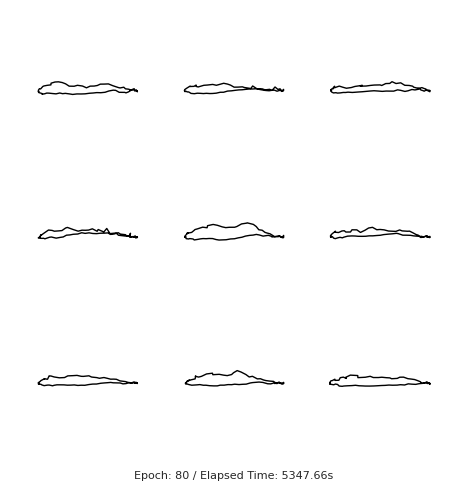

Saving model checkpoints...

Epoch 81/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


Discriminator Loss: 1.3860, Generator Loss: 0.7138, Time: 67.62s
Generating and plotting airfoils...


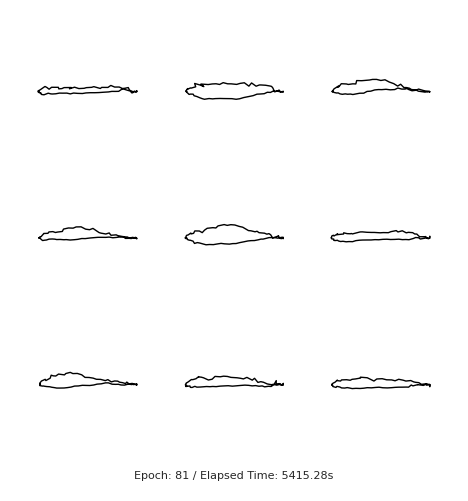


Epoch 82/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3881, Generator Loss: 0.7140, Time: 67.73s
Generating and plotting airfoils...


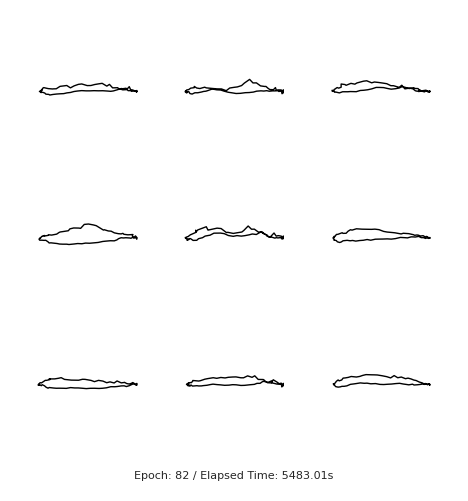


Epoch 83/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


Discriminator Loss: 1.3863, Generator Loss: 0.7083, Time: 67.52s
Generating and plotting airfoils...


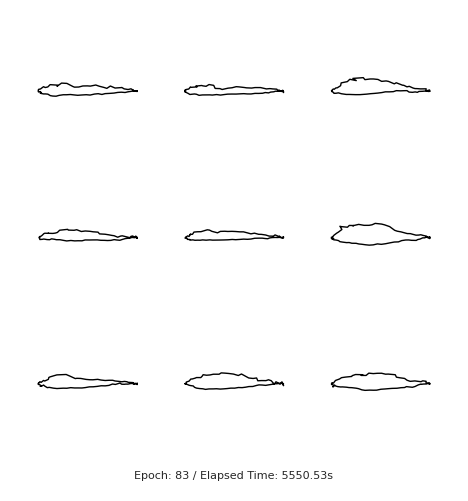


Epoch 84/100


Training: 100%|██████████| 68/68 [01:08<00:00,  1.01s/it]


Discriminator Loss: 1.3871, Generator Loss: 0.7083, Time: 68.92s
Generating and plotting airfoils...


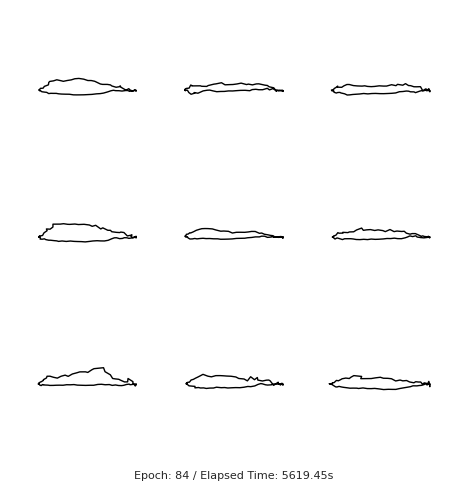


Epoch 85/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3866, Generator Loss: 0.7076, Time: 67.73s
Generating and plotting airfoils...


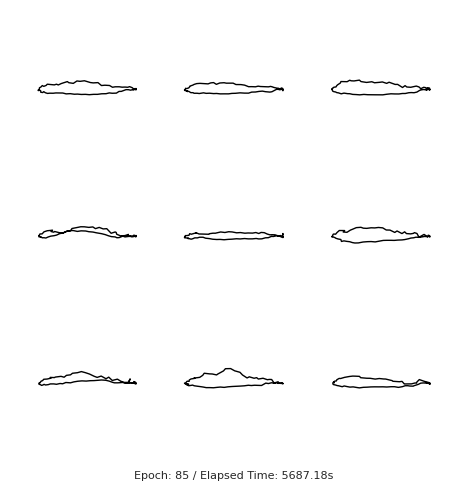

Saving model checkpoints...

Epoch 86/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3869, Generator Loss: 0.7105, Time: 67.83s
Generating and plotting airfoils...


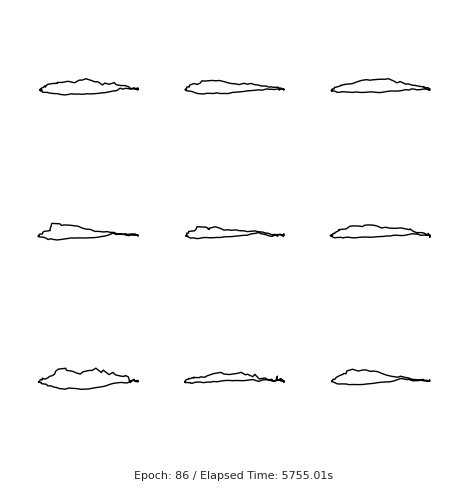


Epoch 87/100


Training: 100%|██████████| 68/68 [01:08<00:00,  1.01s/it]


Discriminator Loss: 1.3872, Generator Loss: 0.7104, Time: 68.92s
Generating and plotting airfoils...


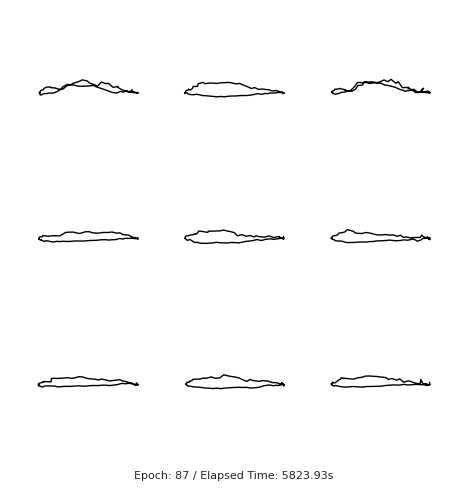


Epoch 88/100


Training: 100%|██████████| 68/68 [01:08<00:00,  1.00s/it]


Discriminator Loss: 1.3871, Generator Loss: 0.7099, Time: 68.23s
Generating and plotting airfoils...


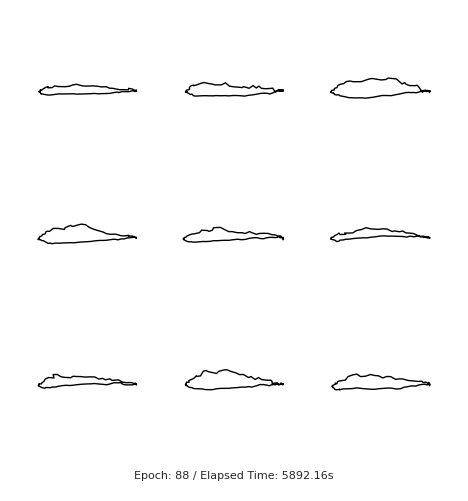


Epoch 89/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


Discriminator Loss: 1.3898, Generator Loss: 0.7189, Time: 67.48s
Generating and plotting airfoils...


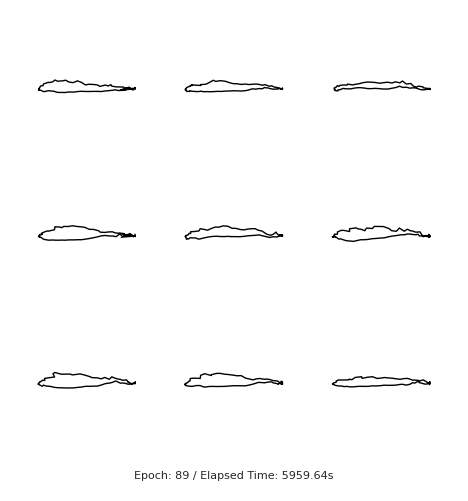


Epoch 90/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


Discriminator Loss: 1.3881, Generator Loss: 0.7148, Time: 67.56s
Generating and plotting airfoils...


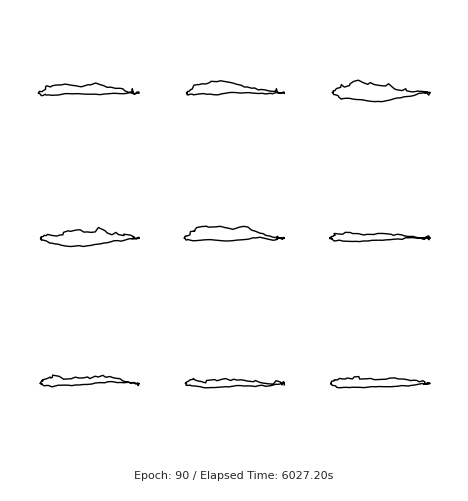

Saving model checkpoints...

Epoch 91/100


Training: 100%|██████████| 68/68 [01:09<00:00,  1.03s/it]


Discriminator Loss: 1.3873, Generator Loss: 0.7042, Time: 69.72s
Generating and plotting airfoils...


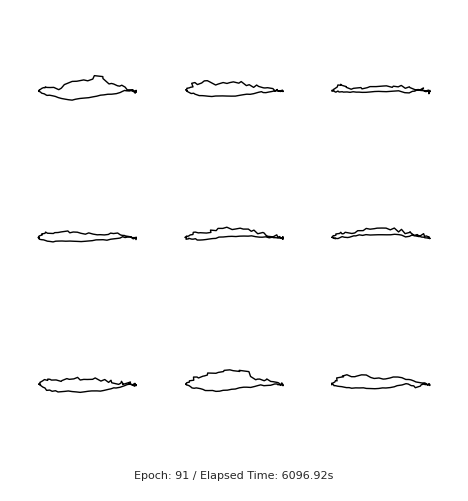


Epoch 92/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3861, Generator Loss: 0.7030, Time: 67.93s
Generating and plotting airfoils...


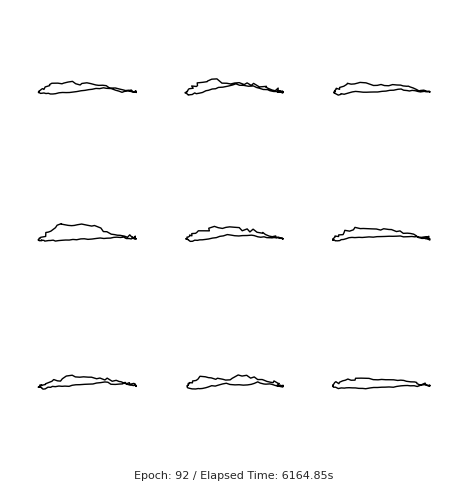


Epoch 93/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3870, Generator Loss: 0.7076, Time: 67.75s
Generating and plotting airfoils...


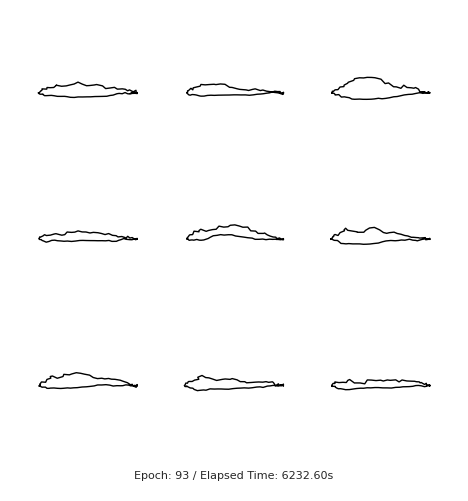


Epoch 94/100


Training: 100%|██████████| 68/68 [01:09<00:00,  1.01s/it]


Discriminator Loss: 1.3878, Generator Loss: 0.7091, Time: 69.02s
Generating and plotting airfoils...


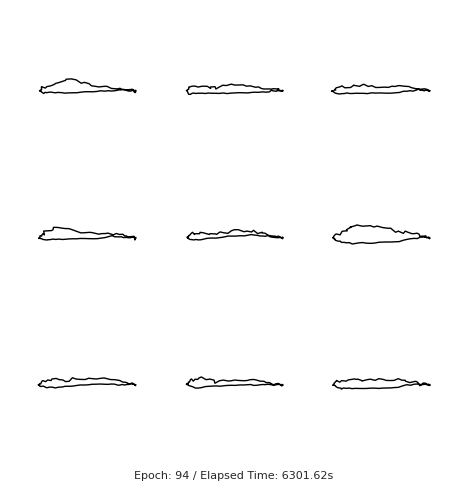


Epoch 95/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


Discriminator Loss: 1.3862, Generator Loss: 0.7016, Time: 67.16s
Generating and plotting airfoils...


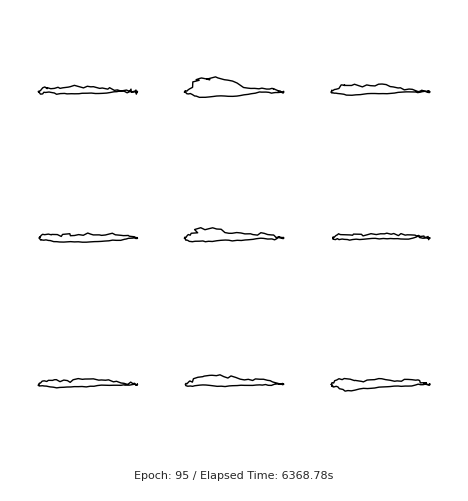

Saving model checkpoints...

Epoch 96/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3870, Generator Loss: 0.7052, Time: 67.70s
Generating and plotting airfoils...


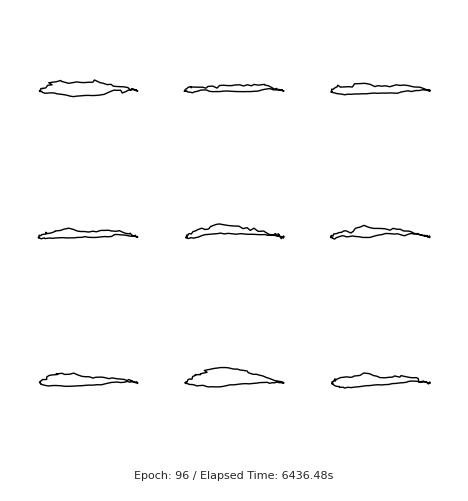


Epoch 97/100


Training: 100%|██████████| 68/68 [01:09<00:00,  1.02s/it]


Discriminator Loss: 1.3867, Generator Loss: 0.7064, Time: 69.23s
Generating and plotting airfoils...


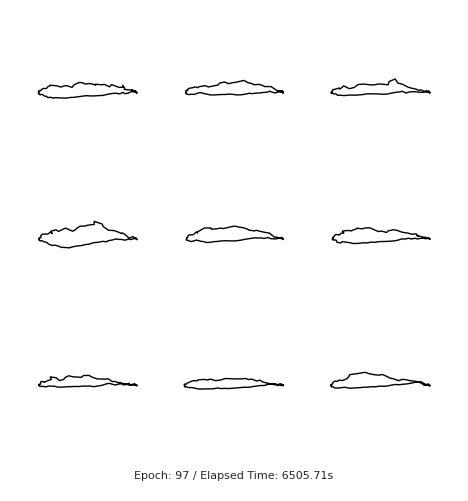


Epoch 98/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3868, Generator Loss: 0.7021, Time: 67.92s
Generating and plotting airfoils...


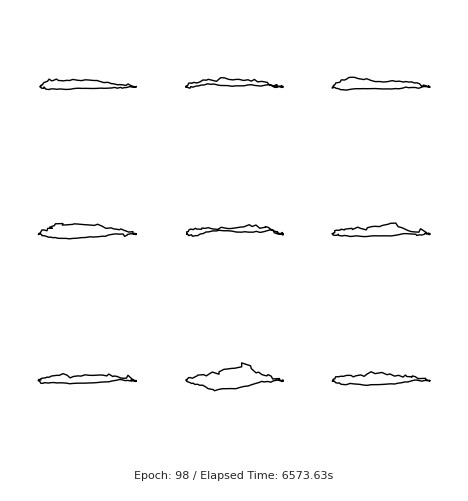


Epoch 99/100


Training: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


Discriminator Loss: 1.3857, Generator Loss: 0.7011, Time: 67.78s
Generating and plotting airfoils...


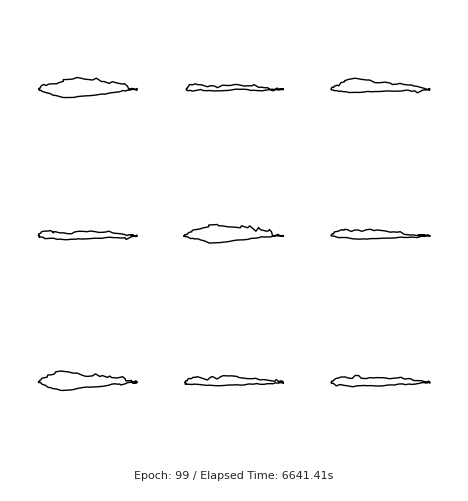


Epoch 100/100


Training: 100%|██████████| 68/68 [01:14<00:00,  1.09s/it]


Discriminator Loss: 1.3893, Generator Loss: 0.7087, Time: 74.10s
Generating and plotting airfoils...


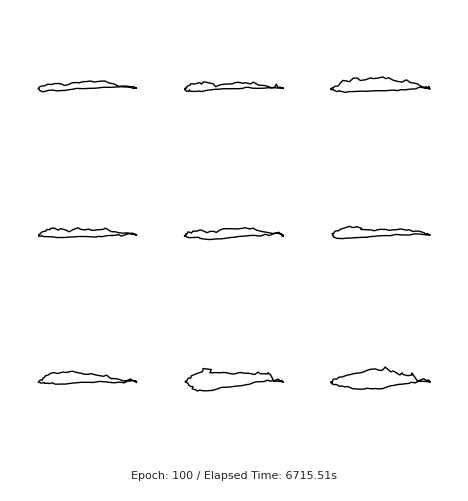

Saving model checkpoints...


In [22]:
generator = Generator(latent_dim = latent_dim, depth=256, n_points=79)
discriminator = Discriminator(depth=8, dense_units=256, n_points=79)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1= 0.5)

generate_and_plot_airfoils(generator, time=0, epoch=0, num_airfoils=9, scale=1, scatter=False, annotate=False, figsize=(2.5, 2.5), linewidth=0.5)

EPOCHS = 100

train(dataset, EPOCHS)

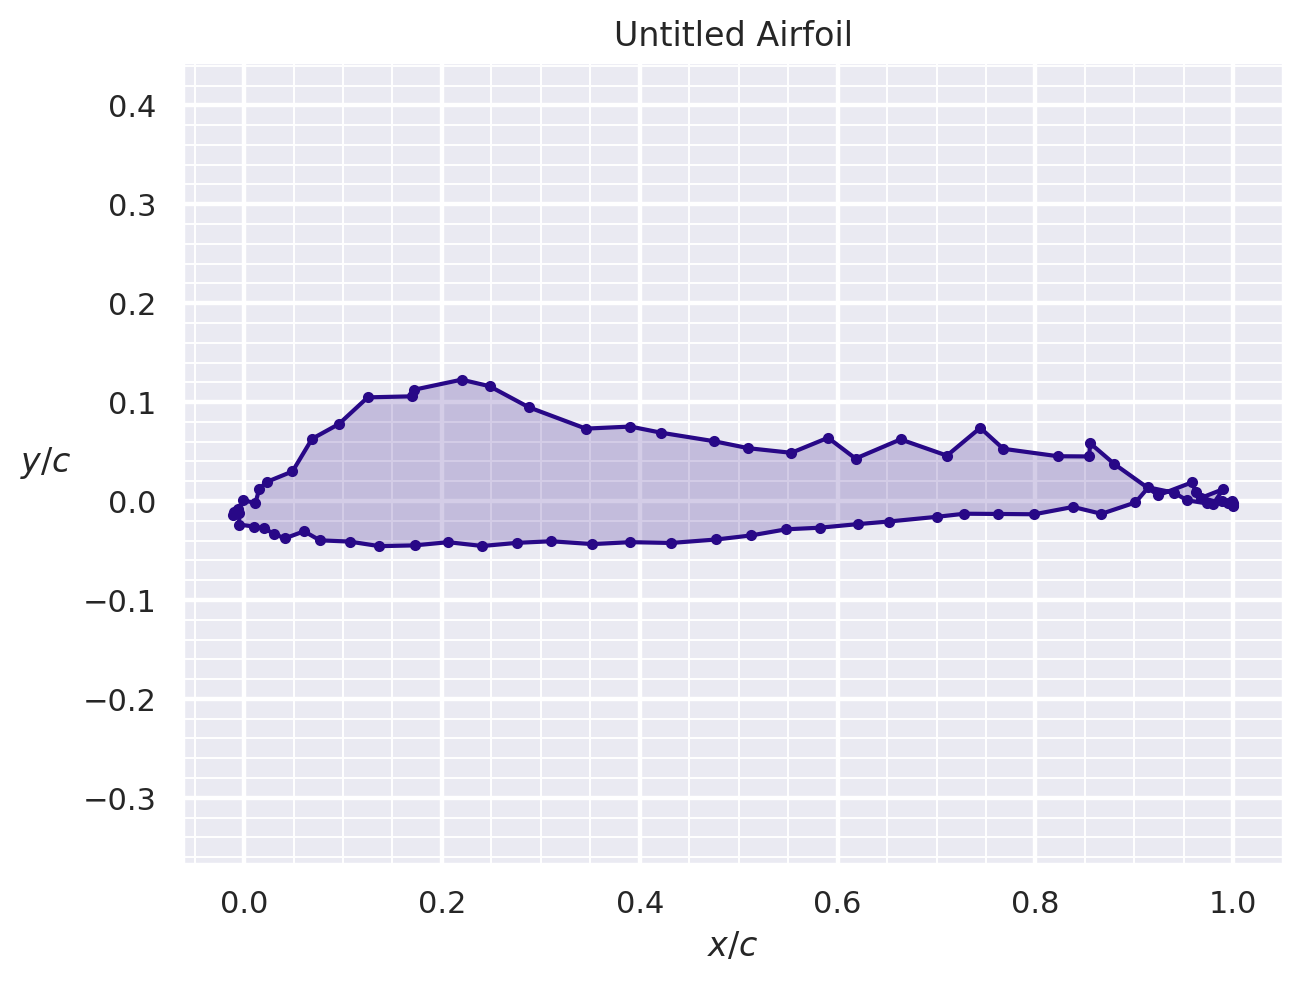

In [25]:
noise = tf.random.normal([1, 128])
generated_coords = generator(noise, training=False)
test = Airfoil(coordinates=generated_coords[0])
test.draw()

In [27]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

import imageio
import glob

anim_file = 'plainGAN_79_points.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./images/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-6wj2gd4c
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-6wj2gd4c
  Resolved https://github.com/tensorflow/docs to commit a81ff2e4ebf518b45cad643d88063c6f2b9e5a1e
  Preparing metadata (setup.py) ... done


<ipython-input-27-7c38c09d13f7>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-27-7c38c09d13f7>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



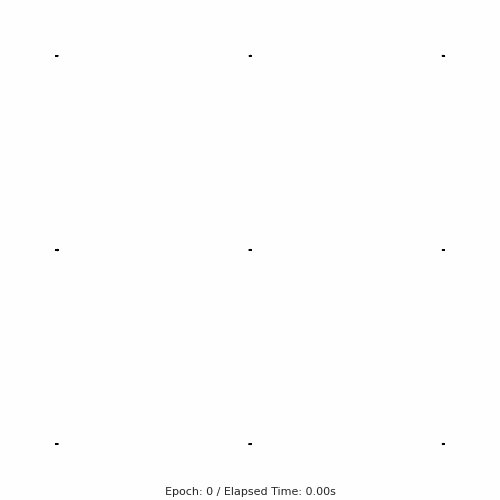

In [30]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)